In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
sys.path.insert(0,"..") 
from glob import glob
from os.path import exists, join

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

import train_utils
import argparse
import skimage.transform
import sklearn.metrics
import models, models.densenet
import datasets, datasets.xray
import torchvision
import torch.nn
import pickle

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('-f', type=str, default="", help='')
parser.add_argument('-name', type=str)
parser.add_argument('--output_dir', type=str, default="/lustre04/scratch/cohenjos/concept-embedding2/")
parser.add_argument('--dataset', type=str, default="nihpcchex")
parser.add_argument('--dataset_dir', type=str, default="not used yet")
parser.add_argument('--model', type=str, default="densenet121")
parser.add_argument('--seed', type=int, default=0, help='')
parser.add_argument('--cuda', type=bool, default=True, help='')
parser.add_argument('--num_epochs', type=int, default=30, help='')
parser.add_argument('--batch_size', type=int, default=64, help='')
parser.add_argument('--shuffle', type=bool, default=True, help='')
parser.add_argument('--lr', type=float, default=0.001, help='')
parser.add_argument('--threads', type=int, default=8, help='')

cfg = parser.parse_args()

In [4]:
#!mkdir $SLURM_TMPDIR/OpenI
#!rsync ~/projects/rpp-bengioy/jpcohen/OpenI/images/NLMCXR_png.tgz $SLURM_TMPDIR/OpenI
#!tar xf $SLURM_TMPDIR/OpenI/NLMCXR_png.tgz -C $SLURM_TMPDIR/OpenI/

In [5]:
#!mkdir $SLURM_TMPDIR/NIH
#!rsync ~/scratch/NIH/images-224.tar $SLURM_TMPDIR/NIH
#!tar xf $SLURM_TMPDIR/NIH/images-224.tar -C $SLURM_TMPDIR/NIH/

In [6]:
#rsync --progress /lustre03/project/6008064/jpcohen/chexpert/CheXpert-v1.0-small.zip $SLURM_TMPDIR/

In [7]:
#os.path.join(os.getenv('SLURM_TMPDIR'), "NIH/images-224")

In [8]:
datasets.xray.default_pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [9]:
toremove = ['Lung Lesion', 'Lung Opacity', 'Enlarged Cardiomediastinum','Fracture']
toremove = []
tokeep = ~np.isin(datasets.xray.default_pathologies, toremove)

In [10]:
dataset_names = ["NIH", "PC", "CheX", "Google", "MIMIC_CH", "MIMIC_NB", "OpenI"]
datasetz = {}

In [11]:
import torchvision, torchvision.transforms
transforms = torchvision.transforms.Compose([datasets.xray.XRayCenterCrop(),datasets.xray.XRayResizer(224)])

datasetz["NIH"] = datasets.xray.NIH_XrayDataset(
        #datadir=os.path.join(os.getenv('SLURM_TMPDIR'), "NIH/images-224"),
        datadir="/lustre04/scratch/cohenjos/NIH/images-224",
        csvpath="/lustre03/project/6008064/jpcohen/ChestXray-NIHCC/Data_Entry_2017.csv")
    
datasetz["PC"] = datasets.xray.PC_XrayDataset(
        datadir="/lustre04/scratch/cohenjos/PC/images-224",
        #datadir="/lustre03/project/6008064/jpcohen/PADCHEST_SJ/images",
        csvpath="/lustre03/project/6008064/jpcohen/PADCHEST_SJ/labels_csv/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv")

datasetz["CheX"] = datasets.xray.CheX_XrayDataset(
        #datadir=os.path.join(os.getenv('SLURM_TMPDIR'), "CheXpert-v1.0-small"),
        datadir="/lustre03/project/6008064/jpcohen/chexpert/CheXpert-v1.0-small",
        csvpath="/lustre03/project/6008064/jpcohen/chexpert/CheXpert-v1.0-small/train.csv",
        transform=transforms)

datasetz["Google"] = datasets.xray.NIH_Google_XrayDataset(datadir="/lustre04/scratch/cohenjos/NIH/images-224",
                                      csvpath="/lustre03/project/6008064/jpcohen/ChestXray-NIHCC/google_labels.csv")

datasetz["MIMIC_CH"] = datasets.xray.MIMIC_XrayDataset(
          datadir="/lustre04/scratch/cohenjos/MIMIC/images-224/files",
          csvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-chexpert.csv.gz",
          metacsvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-metadata.csv.gz")

datasetz["MIMIC_NB"] = datasets.xray.MIMIC_XrayDataset(
          datadir="/lustre04/scratch/cohenjos/MIMIC/images-224/files",
          csvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-negbio.csv.gz",
          metacsvpath="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/mimic-cxr-2.0.0-metadata.csv.gz")

datasetz["OpenI"] = datasets.xray.Openi_XrayDataset(
            datadir="/lustre03/project/6008064/jpcohen/OpenI/images/",
            #datadir=os.path.join(os.getenv('SLURM_TMPDIR'), "OpenI"),
            xmlpath="/lustre03/project/6008064/jpcohen/OpenI/ecgen-radiology/",
            transform=transforms)


In [12]:
#pathologies = ['Consolidation', 'Infiltration','Pneumonia']#, 'Effusion']
pathologies = datasets.xray.default_pathologies

In [13]:
#datasetz["MIMIC_NB"].pathologies

In [14]:
for dataset_name in dataset_names:
    print(dataset_name)
    datasets.xray.relabel_dataset(pathologies, datasetz[dataset_name])

NIH
Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
PC
Lung Lesion doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
CheX
{'Support Devices', 'Pleural Other'} will be dropped
Infiltration doesn't exist. Adding nans instead.
Emphysema doesn't exist. Adding nans instead.
Fibrosis doesn't exist. Adding nans instead.
Pleural_Thickening doesn't exist. Adding nans instead.
Nodule doesn't exist. Adding nans instead.
Mass doesn't exist. Adding nans instead.
Hernia doesn't exist. Adding nans instead.
Google
{'Nodule or mass'} will be dropped
Atelectasis doesn't exist. Adding nans instead.
Consolidation doesn't exist. Adding nans instead.
Infiltration doesn't exist. Adding nans instead.
Edema doesn't exist. Adding nans instead.
Emphysema doesn't

In [15]:
# for dataset_name in dataset_names:
#     print(dataset_name)
#     # apply filter for 1 path only
#     datasetz[dataset_name] = datasets.xray.FilterDataset(datasetz[dataset_name])

In [16]:
datasetz["NIH"]

{'Atelectasis': [(0.0, 29103), (1.0, 1702)],
 'Cardiomegaly': [(0.0, 30038), (1.0, 767)],
 'Consolidation': [(0.0, 30378), (1.0, 427)],
 'Edema': [(0.0, 30723), (1.0, 82)],
 'Effusion': [(0.0, 29525), (1.0, 1280)],
 'Emphysema': [(0.0, 30540), (1.0, 265)],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [(0.0, 30234), (1.0, 571)],
 'Fracture': [],
 'Hernia': [(0.0, 30722), (1.0, 83)],
 'Infiltration': [(0.0, 27201), (1.0, 3604)],
 'Lung Lesion': [],
 'Lung Opacity': [],
 'Mass': [(0.0, 29525), (1.0, 1280)],
 'Nodule': [(0.0, 29144), (1.0, 1661)],
 'Pleural_Thickening': [(0.0, 30042), (1.0, 763)],
 'Pneumonia': [(0.0, 30637), (1.0, 168)],
 'Pneumothorax': [(0.0, 30536), (1.0, 269)]}


NIH_XrayDataset num_samples=30805

In [17]:
datasetz["PC"]

{'Atelectasis': [(0.0, 59674), (1.0, 2441)],
 'Cardiomegaly': [(0.0, 56725), (1.0, 5390)],
 'Consolidation': [(0.0, 61621), (1.0, 494)],
 'Edema': [(0.0, 62007), (1.0, 108)],
 'Effusion': [(0.0, 60478), (1.0, 1637)],
 'Emphysema': [(0.0, 61569), (1.0, 546)],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [(0.0, 61774), (1.0, 341)],
 'Fracture': [(0.0, 60450), (1.0, 1665)],
 'Hernia': [(0.0, 61127), (1.0, 988)],
 'Infiltration': [(0.0, 57677), (1.0, 4438)],
 'Lung Lesion': [],
 'Lung Opacity': [],
 'Mass': [(0.0, 61608), (1.0, 507)],
 'Nodule': [(0.0, 59921), (1.0, 2194)],
 'Pleural_Thickening': [(0.0, 60039), (1.0, 2076)],
 'Pneumonia': [(0.0, 60064), (1.0, 2051)],
 'Pneumothorax': [(0.0, 62017), (1.0, 98)]}


PC_XrayDataset num_samples=62115

In [18]:
datasetz["CheX"]

{'Atelectasis': [(0.0, 14317), (1.0, 12691)],
 'Cardiomegaly': [(0.0, 17765), (1.0, 9099)],
 'Consolidation': [(0.0, 22504), (1.0, 5390)],
 'Edema': [(0.0, 20615), (1.0, 14929)],
 'Effusion': [(0.0, 23500), (1.0, 20640)],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [(0.0, 20506), (1.0, 5181)],
 'Fibrosis': [],
 'Fracture': [(0.0, 14948), (1.0, 4250)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [(0.0, 14422), (1.0, 4217)],
 'Lung Opacity': [(1.0, 30873), (0.0, 15675)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [(0.0, 14793), (1.0, 2822)],
 'Pneumothorax': [(0.0, 32685), (1.0, 4311)]}


CheX_XrayDataset num_samples=64534

In [19]:
datasetz["Google"]

{'Atelectasis': [],
 'Cardiomegaly': [],
 'Consolidation': [],
 'Edema': [],
 'Effusion': [],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [],
 'Fracture': [(0.0, 1635), (1.0, 60)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [],
 'Lung Opacity': [(0.0, 1094), (1.0, 601)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [],
 'Pneumothorax': [(0.0, 1623), (1.0, 72)]}


NIH_Google_XrayDataset num_samples=1695

In [20]:
datasetz["MIMIC_CH"]

{'Atelectasis': [(0.0, 30954), (1.0, 4077)],
 'Cardiomegaly': [(0.0, 32312), (1.0, 3743)],
 'Consolidation': [(0.0, 32297), (1.0, 816)],
 'Edema': [(0.0, 33610), (1.0, 1157)],
 'Effusion': [(0.0, 33401), (1.0, 3713)],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [(0.0, 31505), (1.0, 692)],
 'Fibrosis': [],
 'Fracture': [(0.0, 30961), (1.0, 972)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [(0.0, 31033), (1.0, 1321)],
 'Lung Opacity': [(0.0, 31175), (1.0, 5426)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [(0.0, 33347), (1.0, 2176)],
 'Pneumothorax': [(0.0, 33651), (1.0, 560)]}


MIMIC_XrayDataset num_samples=45628

In [21]:
datasetz["MIMIC_NB"]

{'Atelectasis': [(0.0, 32058), (1.0, 4048)],
 'Cardiomegaly': [(0.0, 33431), (1.0, 3275)],
 'Consolidation': [(0.0, 33564), (1.0, 762)],
 'Edema': [(0.0, 34731), (1.0, 1121)],
 'Effusion': [(0.0, 34489), (1.0, 3595)],
 'Emphysema': [],
 'Enlarged Cardiomediastinum': [(0.0, 32641), (1.0, 660)],
 'Fibrosis': [],
 'Fracture': [(0.0, 32320), (1.0, 696)],
 'Hernia': [],
 'Infiltration': [],
 'Lung Lesion': [(0.0, 32187), (1.0, 1271)],
 'Lung Opacity': [(0.0, 32371), (1.0, 5301)],
 'Mass': [],
 'Nodule': [],
 'Pleural_Thickening': [],
 'Pneumonia': [(0.0, 34479), (1.0, 2042)],
 'Pneumothorax': [(0.0, 34760), (1.0, 500)]}


MIMIC_XrayDataset num_samples=45628

In [22]:
datasetz["OpenI"]

{'Atelectasis': [(0.0, 2996), (1.0, 271)],
 'Cardiomegaly': [(0.0, 3082), (1.0, 185)],
 'Consolidation': [],
 'Edema': [(0.0, 3217), (1.0, 50)],
 'Effusion': [(0.0, 3147), (1.0, 120)],
 'Emphysema': [(0.0, 3183), (1.0, 84)],
 'Enlarged Cardiomediastinum': [],
 'Fibrosis': [(0.0, 3250), (1.0, 17)],
 'Fracture': [(0.0, 3189), (1.0, 78)],
 'Hernia': [(0.0, 3226), (1.0, 41)],
 'Infiltration': [(0.0, 3201), (1.0, 66)],
 'Lung Lesion': [(0.0, 3264), (1.0, 3)],
 'Lung Opacity': [(0.0, 2940), (1.0, 327)],
 'Mass': [(0.0, 3261), (1.0, 6)],
 'Nodule': [(0.0, 3199), (1.0, 68)],
 'Pleural_Thickening': [(0.0, 3237), (1.0, 30)],
 'Pneumonia': [(0.0, 3199), (1.0, 68)],
 'Pneumothorax': [(0.0, 3253), (1.0, 14)]}


Openi_XrayDataset num_samples=3267

In [23]:
train_datasets = {}
test_datasets = {}
test_loaders = {}
for dataset_name in dataset_names:
    train_size = int(0.5 * len(datasetz[dataset_name]))
    test_size = len(datasetz[dataset_name]) - train_size
    torch.manual_seed(0)
    train_datasets[dataset_name], test_datasets[dataset_name] = torch.utils.data.random_split(datasetz[dataset_name], [train_size, test_size])
    
    #fix labels
    train_datasets[dataset_name].labels = datasetz[dataset_name].labels[train_datasets[dataset_name].indices]
    test_datasets[dataset_name].labels = datasetz[dataset_name].labels[test_datasets[dataset_name].indices]
    
    test_loaders[dataset_name] = torch.utils.data.DataLoader(test_datasets[dataset_name],
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=32, pin_memory=cfg.cuda)
    

In [24]:
# model = models.densenet.DenseNet(num_classes=len(datasets.xray.default_pathologies), in_channels=1, 
#                                  **models.densenet.get_densenet_params("densenet121"))

In [25]:
def plot_aucs(model_names, title):
    plt.figure(0, figsize=(35, 2), dpi=300)
    lines = []
    colors = ["red", "blue", "orange"]
    #for i in range(5):
    num_path = len(datasets.xray.default_pathologies)-3
    i = -1
    for x in range(num_path):
        i += 1
        res = results[list(results)[0]] # just to filter. This should be done better
        all_labels = res[3]
        if datasets.xray.default_pathologies[i] in toremove:
            i -= 1
            continue
        elif (all_labels[i] == 0).all():
            print("|", datasets.xray.default_pathologies[i], "|", "ERR |")
            ax = plt.subplot2grid((1,num_path),(0,i))
            ax.axis('off')
        else:
#             xplot = i // (num_path//2)
#             yplot = i % (num_path//2)
#             ax = plt.subplot2grid((2, (num_path//2)), (xplot, yplot))
            ax = plt.subplot2grid((1,num_path),(0,i))
            legend = []
            for j, model_name in enumerate(model_names):

                res = results[model_name]
                all_labels = res[3]
                all_outputs = res[2]
                # Save ROC curve
                fpr, tpr, thres = sklearn.metrics.roc_curve(all_labels[i], all_outputs[i])

                auc = sklearn.metrics.roc_auc_score(all_labels[i], all_outputs[i])
                

                # if the model was trained on this label
                if model_name == "Merge" or np.nansum(datasetz[model_name].labels[:,i]) > 0:
                    line = ax.plot(fpr, tpr, label=model_name)#, color=colors[j])
                    legend.append(model_name + "=" + str(auc)[:4])
                else:
                    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1))
                    legend.append(model_name + "=N/A")
                if i == 0:
                    lines.append(line[0])

            ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), c="black")
            ax.set_title(datasets.xray.default_pathologies[i] + "\n(N={})".format(int(np.nansum(all_labels[i]))))
            ax.tick_params(top=False, bottom=False, left=False, right=False)
            ax.set_yticks([0, 0.5, 1])
            if i > 0:
                ax.set_yticks([])

            plt.subplots_adjust(hspace = 0.5)
            plt.legend(handles=lines,
                       labels=legend,
                       title="Model",
                       prop={'size': 9},
                       #bbox_to_anchor=(1.1, 1.05)
                       )
    #plt.subplots_adjust(top=0.5)
    plt.subplots_adjust(wspace=0.1)
    plt.suptitle(title, y=1.2)
    plt.show();
    plt.tight_layout();


In [26]:
#plot_aucs(model_names, "Testset:" + testset_name)

In [27]:
datasets.xray.default_pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [28]:
#!ls /home/cohenjos/scratch/concept-embedding2/*best* | grep -v XrayDataset

In [29]:
model_names = ["NIH", "PC", "CheX", "MIMIC_CH", "MIMIC_NB","nih-pc-chex-mimic_ch-google-openi"]# "nihpcchexmimic_chmimic_nbgoogle"]
#model_names = ["NIH"]#, "PC", "CheX"]

In [30]:
testset_names = ["NIH", "PC", "CheX", "Google", "MIMIC_CH", "MIMIC_NB", "OpenI"]
#testset_names = ["NIH_Google"]

In [31]:
testset_names

['NIH', 'PC', 'CheX', 'Google', 'MIMIC_CH', 'MIMIC_NB', 'OpenI']

In [32]:
# for hold one dataset out
dataset_names2 = ["NIH", "PC", "CheX", "MIMIC_CH", "Google", "OpenI"]
for testset_name in dataset_names2:
    m = dataset_names2.copy()
    m.remove(testset_name)
    model_name = "-".join(m).lower()
    print(testset_name, model_name)
    path = "results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name)
    print(path)
    if os.path.exists(path):
        print("skipping", testset_name, model_name)
        continue
    results_model = {}
    for seed in range(3):
        model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(model_name.lower(), seed))
        results_model[seed] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)

    pickle.dump(results_model, open(path, "bw"))
    

NIH pc-chex-mimic_ch-google-openi
results-da-new-seeds-tsNIH-mpc-chex-mimic_ch-google-openi.pkl
skipping NIH pc-chex-mimic_ch-google-openi
PC nih-chex-mimic_ch-google-openi
results-da-new-seeds-tsPC-mnih-chex-mimic_ch-google-openi.pkl
skipping PC nih-chex-mimic_ch-google-openi
CheX nih-pc-mimic_ch-google-openi
results-da-new-seeds-tsCheX-mnih-pc-mimic_ch-google-openi.pkl
skipping CheX nih-pc-mimic_ch-google-openi
MIMIC_CH nih-pc-chex-google-openi
results-da-new-seeds-tsMIMIC_CH-mnih-pc-chex-google-openi.pkl
skipping MIMIC_CH nih-pc-chex-google-openi
Google nih-pc-chex-mimic_ch-openi
results-da-new-seeds-tsGoogle-mnih-pc-chex-mimic_ch-openi.pkl
skipping Google nih-pc-chex-mimic_ch-openi
OpenI nih-pc-chex-mimic_ch-google
results-da-new-seeds-tsOpenI-mnih-pc-chex-mimic_ch-google.pkl
skipping OpenI nih-pc-chex-mimic_ch-google


In [33]:
for testset_name in testset_names:
    for model_name in model_names:
        print(testset_name, model_name)
        path = "results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name)
        if os.path.exists(path):
            print("skipping", testset_name, model_name)
            continue
        results_model = {}
        for seed in range(3):
            model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(model_name.lower(), seed))
            results_model[seed] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)

        pickle.dump(results_model, open(path, "bw"))
    

NIH NIH
skipping NIH NIH
NIH PC
skipping NIH PC
NIH CheX
skipping NIH CheX
NIH MIMIC_CH
skipping NIH MIMIC_CH
NIH MIMIC_NB
skipping NIH MIMIC_NB
NIH nih-pc-chex-mimic_ch-google-openi
skipping NIH nih-pc-chex-mimic_ch-google-openi
PC NIH
skipping PC NIH
PC PC
skipping PC PC
PC CheX
skipping PC CheX
PC MIMIC_CH
skipping PC MIMIC_CH
PC MIMIC_NB
skipping PC MIMIC_NB
PC nih-pc-chex-mimic_ch-google-openi
skipping PC nih-pc-chex-mimic_ch-google-openi
CheX NIH
skipping CheX NIH
CheX PC
skipping CheX PC
CheX CheX
skipping CheX CheX
CheX MIMIC_CH
skipping CheX MIMIC_CH
CheX MIMIC_NB
skipping CheX MIMIC_NB
CheX nih-pc-chex-mimic_ch-google-openi
skipping CheX nih-pc-chex-mimic_ch-google-openi
Google NIH
skipping Google NIH
Google PC
skipping Google PC
Google CheX
skipping Google CheX
Google MIMIC_CH
skipping Google MIMIC_CH
Google MIMIC_NB
skipping Google MIMIC_NB
Google nih-pc-chex-mimic_ch-google-openi
skipping Google nih-pc-chex-mimic_ch-google-openi
MIMIC_CH NIH
skipping MIMIC_CH NIH
MIMIC_CH 

In [34]:
# for model_name in ["MIMIC_CH", "MIMIC_NB", "nihpcchexmimic_chmimic_nbgoogle"]:
#     if model_name == "Merge":
#         model = torch.load("/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt")
#     else:
#         model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt".format(model_name.lower()))
#     results[model_name] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)


In [ ]:
#plot_aucs(model_names, "Testset:" + testset_name)

In [ ]:
# pickle.dump(results, open("results-da-new-{}.pkl".format(testset_name), "bw"))


In [ ]:
# testset_name = "NIH"
# results = pickle.load(open("results-da-new-seeds-{}.pkl".format(testset_name), "br"))

In [27]:
def get_avg_auc(results):
    resultsnew = {}
    for model_name in results.keys():
        resultsnew[model_name] = {}
        resultsnew[model_name][0] = {} # single seed now
        resultsnew[model_name][0][2] = {}
        resultsnew[model_name][0][3] = {}
        task_aucs = []
        overall_auc = []
        for task in range(len(results[model_name][0][2])):
            avg = [results[model_name][seed][2][task] for seed in range(3)] # 3 seeds
            gt = results[model_name][0][3][task]
            avg = np.asarray(avg).mean(0)
            resultsnew[model_name][0][2][task] = avg
            resultsnew[model_name][0][3][task] = gt
            if len(np.unique(gt))> 1:
                task_auc = sklearn.metrics.roc_auc_score(gt, avg)
                task_aucs.append(task_auc)
            else:
                task_aucs.append(np.nan)
            
        for seed in range(3):
            overall_auc.append(results[model_name][seed][0])
        resultsnew[model_name][0][0] = np.array(overall_auc).mean()
        resultsnew[model_name][0][1] = np.array(task_aucs)
        
    return resultsnew

In [28]:
pathologies = datasets.xray.default_pathologies
neworder = ['Pneumothorax',
            'Effusion',
            'Atelectasis',
             'Edema',
             'Fracture',
             'Lung Opacity',
             'Lung Lesion',
             'Cardiomegaly',
             'Enlarged Cardiomediastinum',
             'Emphysema',
             'Fibrosis',
             'Pleural_Thickening',
             'Nodule',
             'Mass',
             'Hernia',
            'Pneumonia',
            'Consolidation',
            'Infiltration',]
neworder_idx = [pathologies.index(path) for path in neworder]

In [29]:
# model_names = ["nihpcchexmimic_chmimic_nbgoogle", "NIH", "PC", "CheX", "MIMIC_CH", "MIMIC_NB"]
# dataset_names = ['NIH', 'PC', 'NIH_Google', 'CheX', 'MIMIC_CH', 'MIMIC_NB', 'OpenI']

In [152]:
model_names = ["PC","NIH","MIMIC_NB", "MIMIC_CH" ,"CheX" ,"nih-pc-chex-mimic_ch-google-openi"]
dataset_names = ["PC","NIH","MIMIC_NB", "MIMIC_CH" ,"CheX",'OpenI',  'Google' ]

In [153]:
# model_names = model_names + ['pc-chex-mimic_ch-google-openi',
#  'nih-chex-mimic_ch-google-openi',
#  'nih-pc-mimic_ch-google-openi',
#  'nih-pc-chex-google-openi',
#  'nih-pc-chex-mimic_ch-openi',
#  'nih-pc-chex-mimic_ch-google']

In [154]:
results_all = {}
for ii, testset_name in enumerate(dataset_names):
    results_all[testset_name] = {}
    for model_name in model_names:
        results_all[testset_name][model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

    # to avg over seeds
    results_all[testset_name] = get_avg_auc(results_all[testset_name])
    

In [33]:
overall_score = []
#for each task
for taski, task in enumerate(datasets.xray.default_pathologies):
    # y = train    x = test
    toplot = np.zeros([len(dataset_names),len(model_names)])*np.nan
    for i,train in enumerate(model_names):
        if train != "nih-pc-chex-mimic_ch-google-openi":
            valid = (np.nansum(datasetz[train].labels, axis=0) > 0)[taski]
        for j, test in enumerate(dataset_names):
            if train != "nih-pc-chex-mimic_ch-google-openi":
                if ~valid:
                    continue
            
            toplot[j,i] = results_all[test][train][0][1][taski]
    overall_score.append(np.nanmean(toplot))


In [45]:
neworder = np.argsort(overall_score)[::-1]

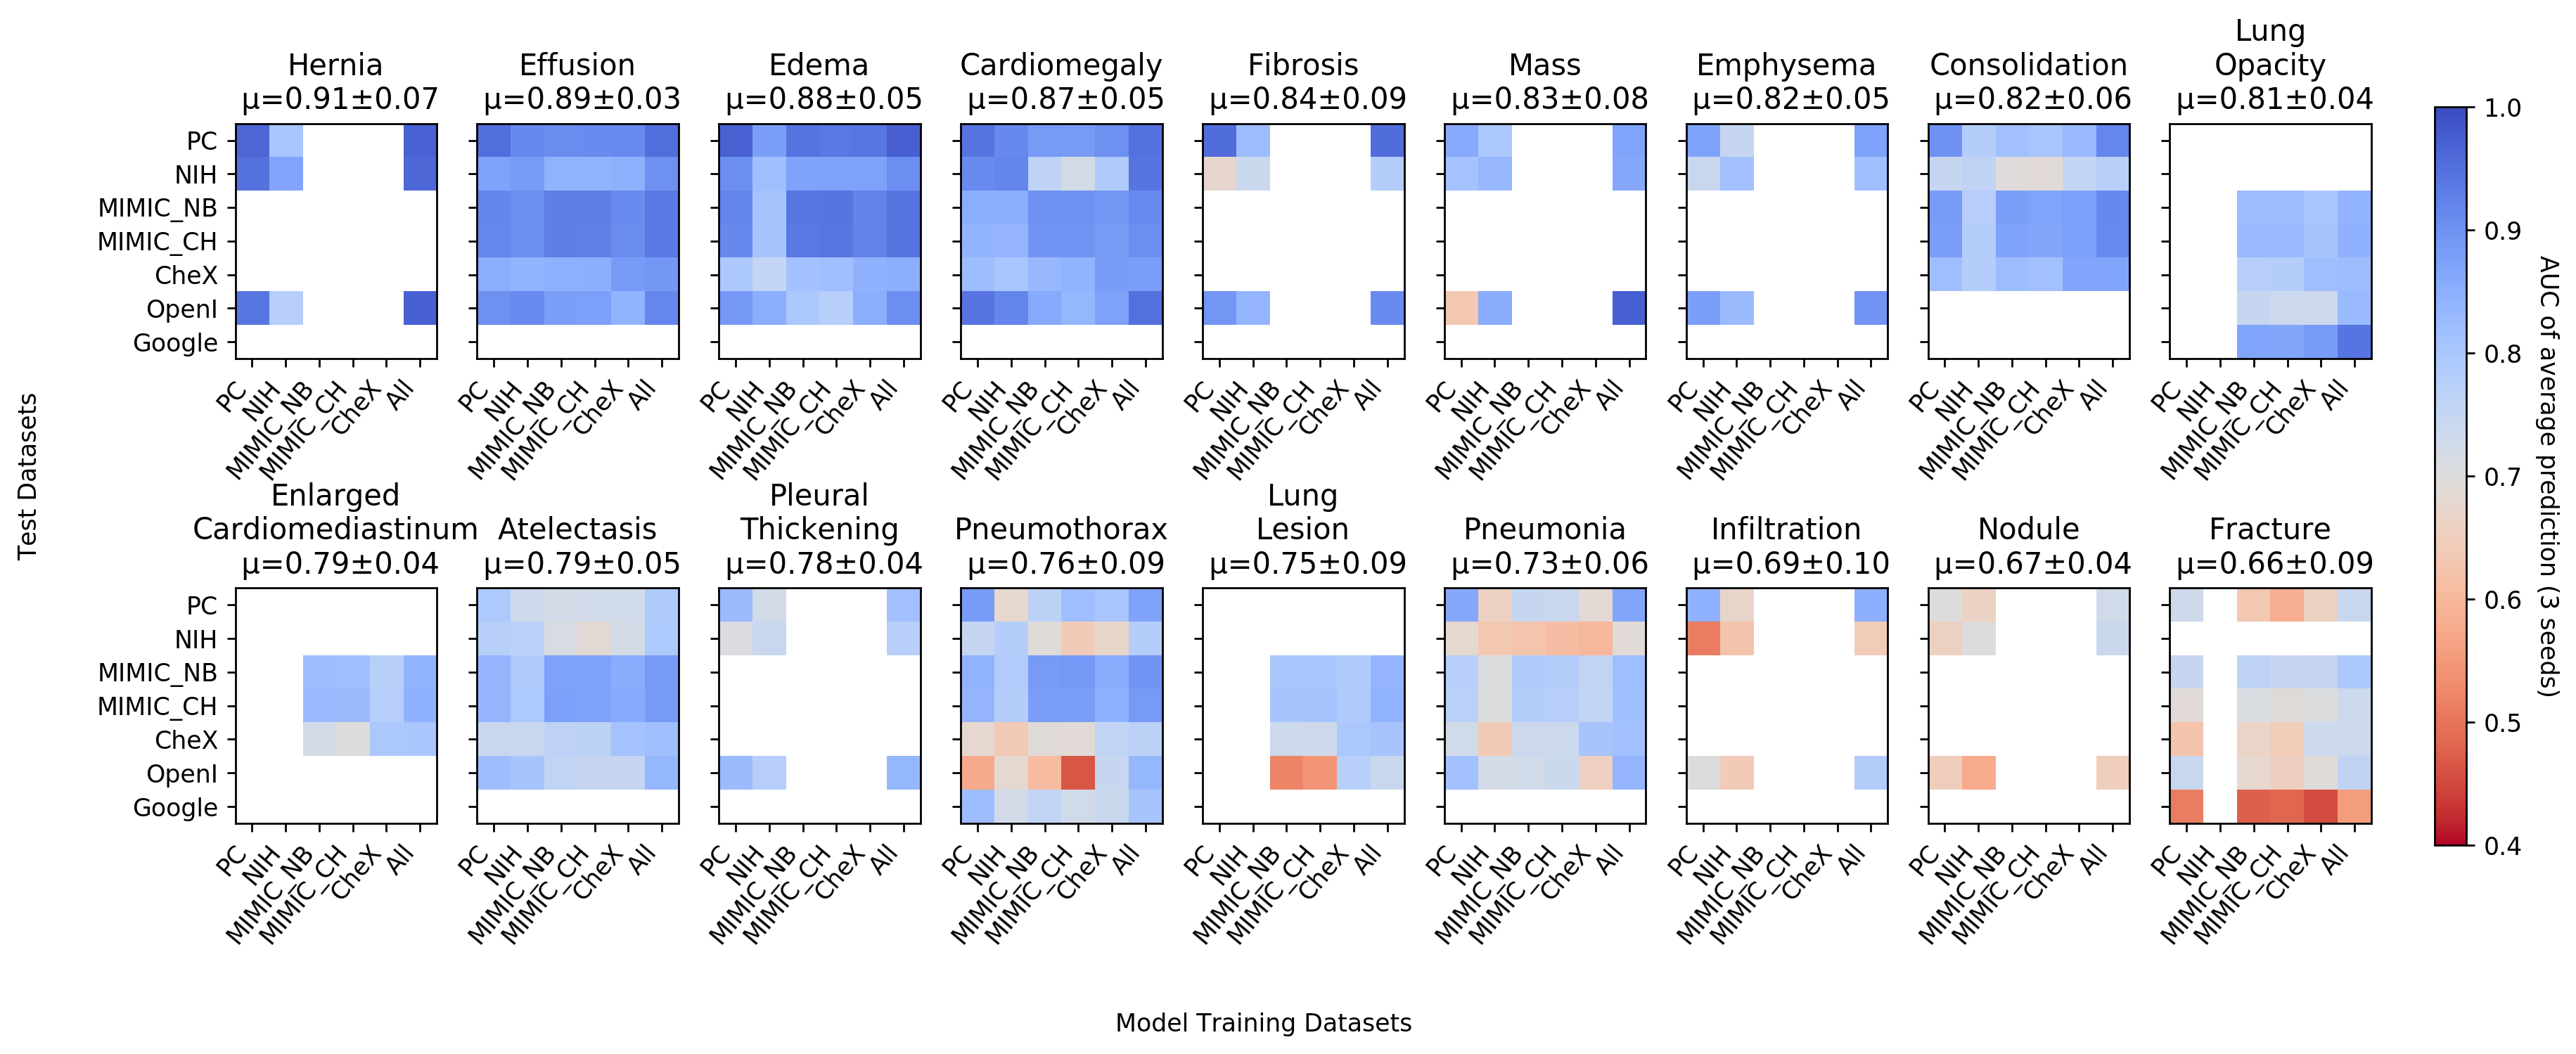

In [46]:
fig, axs = plt.subplots(2, 9, figsize=(18, 6), dpi=250, sharey=True, sharex=False)

#for each task
for index, task in enumerate(np.asarray(datasets.xray.default_pathologies)[neworder]):
    
    taski = datasets.xray.default_pathologies.index(task)

    # y = train    x = test
    toplot = np.zeros([len(dataset_names),len(model_names)])*np.nan
    for i,train in enumerate(model_names):
        if train != "nih-pc-chex-mimic_ch-google-openi":
            valid = (np.nansum(datasetz[train].labels, axis=0) > 0)[taski]
        for j, test in enumerate(dataset_names):
            if train != "nih-pc-chex-mimic_ch-google-openi":
                if ~valid:
                    continue
            
            toplot[j,i] = results_all[test][train][0][1][taski]
    
    ax = axs[index//9,index%9]
    im = ax.imshow(toplot, vmin=0.4, vmax=1, cmap="coolwarm_r") #cmap="hsv"
    ax.set_title(task.replace("_"," ").replace(" ","\n") + "\n μ=" + str(np.nanmean(toplot))[:4] + "±" + str(np.nanstd(toplot))[:4])
    ax.set_xticks(range(len(model_names)));
    model_namesz = [n.replace("nih-pc-chex-mimic_ch-google-openi", "All") for n in model_names]
    ax.set_xticklabels(model_namesz)
    plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')

    ax.set_yticks(range(len(dataset_names)));
    ax.set_yticklabels(dataset_names)
    
fig.text(0.45, -0.02, 'Model Training Datasets', ha='center', va='center')
fig.text(0.06, 0.5, 'Test Datasets', ha='center', va='center', rotation='vertical')

    
fig.subplots_adjust(right=0.80, hspace=0.4)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax);
cbar.set_label('AUC of average prediction (3 seeds)', rotation=270, labelpad=15)


In [35]:
dataset_names2 = ["NIH", "PC", "CheX", "MIMIC_CH", "Google", "OpenI"]
all_models = "-".join(dataset_names2).lower()
results_all = {}
models_toplot = []
for testset_name in dataset_names2:
    
    if ((testset_name == "Google") or (testset_name == "OpenI")):
        continue
    results_all[testset_name] = {}
    m = dataset_names2.copy()
    m.remove(testset_name)
    model_name = "-".join(m).lower()
    print(testset_name, model_name)
    path = "results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name)
    print(path)
    results_all[testset_name][model_name] = pickle.load(open(path, "br"))
    
    models_toplot.append((testset_name, model_name, all_models))
    
    model_name = testset_name
    path = "results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name)
    print(path)
    results_all[testset_name][model_name] = pickle.load(open(path, "br"))
    
    
    model_name = all_models
    path = "results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name)
    print(path)
    results_all[testset_name][model_name] = pickle.load(open(path, "br"))
    
#     # average
#     results_all[testset_name] = get_avg_auc(results_all[testset_name])
    
    
    

NIH pc-chex-mimic_ch-google-openi
results-da-new-seeds-tsNIH-mpc-chex-mimic_ch-google-openi.pkl
results-da-new-seeds-tsNIH-mNIH.pkl
results-da-new-seeds-tsNIH-mnih-pc-chex-mimic_ch-google-openi.pkl
PC nih-chex-mimic_ch-google-openi
results-da-new-seeds-tsPC-mnih-chex-mimic_ch-google-openi.pkl
results-da-new-seeds-tsPC-mPC.pkl
results-da-new-seeds-tsPC-mnih-pc-chex-mimic_ch-google-openi.pkl
CheX nih-pc-mimic_ch-google-openi
results-da-new-seeds-tsCheX-mnih-pc-mimic_ch-google-openi.pkl
results-da-new-seeds-tsCheX-mCheX.pkl
results-da-new-seeds-tsCheX-mnih-pc-chex-mimic_ch-google-openi.pkl
MIMIC_CH nih-pc-chex-google-openi
results-da-new-seeds-tsMIMIC_CH-mnih-pc-chex-google-openi.pkl
results-da-new-seeds-tsMIMIC_CH-mMIMIC_CH.pkl
results-da-new-seeds-tsMIMIC_CH-mnih-pc-chex-mimic_ch-google-openi.pkl


In [36]:
toplot1 = []
toplot1_names = []
toplot2 = []
toplot2_names = []
toplot3 = []
for (m1,ma,al) in models_toplot:
    toplot1_names.append(m1)
    toplot2_names.append(ma)
    toplot1.append([results_all[m1][m1][seed][0] for seed in range(3)])
    toplot2.append([results_all[m1][ma][seed][0] for seed in range(3)])
    toplot3.append([results_all[m1][al][seed][0] for seed in range(3)])
toplot1 = np.array(toplot1)
toplot2 = np.array(toplot2)
toplot3 = np.array(toplot3)

In [44]:
toplot3.std(1)

array([0.00223847, 0.00042572, 0.00066983, 0.00157433])

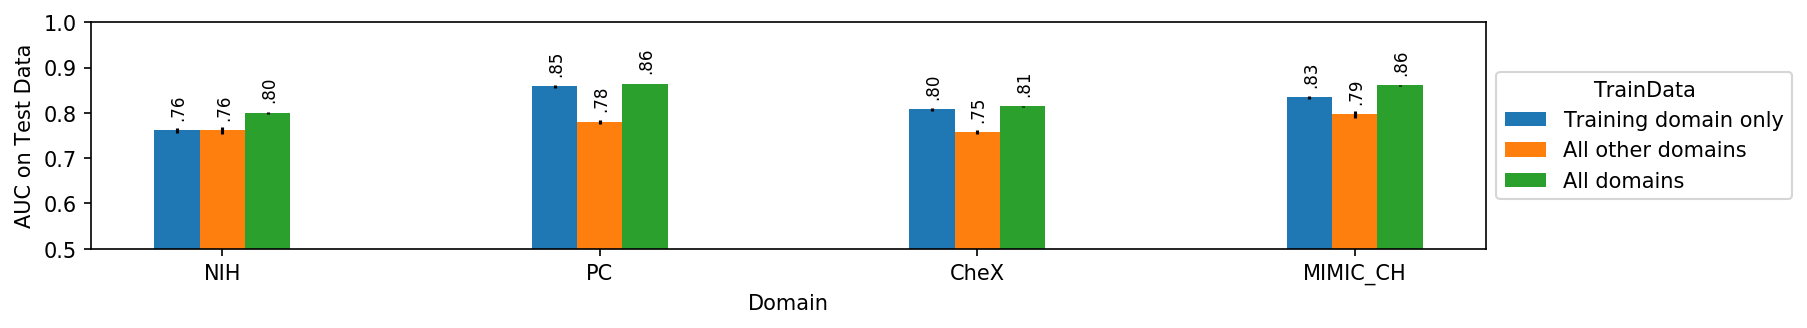

In [100]:
plt.figure(0, figsize=(12, 2), dpi=150)
#plt.bar(range(len(toplot)),results/toplot.max())
index = np.arange(len(toplot1))  # the label locations
width = 0.12  # the width of the bars

plt.bar(index-0.12+0*width, toplot1.mean(1), width, yerr=toplot1.std(1), label="Training domain only");
for i, v in enumerate(toplot1.mean(1)):
    plt.text(i-0.08+0*width-width/2,v+0.05, str(v)[1:4], color='black', fontsize=8, rotation='90')
    
plt.bar(index-0.12+1*width, toplot2.mean(1), width, yerr=toplot2.std(1), label="All other domains");
for i, v in enumerate(toplot2.mean(1)):
    plt.text(i-0.08+1*width-width/2,v+0.05, str(v)[1:4], color='black', fontsize=8, rotation='90')
    
plt.bar(index-0.12+2*width, toplot3.mean(1), width, yerr=toplot3.std(1), label="All domains");
for i, v in enumerate(toplot3.mean(1)):
    plt.text(i-0.08+2*width-width/2,v+0.05, str(v)[1:4], color='black', fontsize=8, rotation='90')
    
plt.xticks(index,np.array(toplot1_names));
plt.xlabel("Domain")
plt.ylabel("AUC on Test Data")

# plt.title("Relative L2 distance between each weight vector")
plt.legend(title="TrainData", loc='center left', bbox_to_anchor=(1, 0.5));
plt.ylim(0.5,1);

In [83]:
!ls /home/cohenjos/scratch/concept-embedding2/*best* | grep -v densenet121

/home/cohenjos/scratch/concept-embedding2/nih-resnet101-r101-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/nih-shufflenet_v2_x2_0-sn22-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/pc-resnet101-r101-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/pc-shufflenet_v2_x2_0-sn22-tw-lr001-rot45-tr15-sc15-seed0-best.pt


In [115]:
# for testset_name in ["NIH", "PC"]:
#     model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-resnet101-r101-tw-lr001-rot45-tr15-sc15-seed-best.pt".format(testset_name.lower()))
#     results_all[testset_name]["{}-r101".format(testset_name)] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)


In [114]:
# for testset_name in ["NIH", "PC"]:
#     model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-shufflenet_v2_x2_0-sn22-tw-lr001-rot45-tr15-sc15-seed1-best.pt".format(testset_name.lower()))
#     results_all[testset_name]["{}-sn22".format(testset_name)] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[testset_name], torch.nn.BCEWithLogitsLoss(), limit=5000)


In [159]:
model_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']
dataset_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']

In [177]:
op_points = {}
for i in range(len(datasets.xray.default_pathologies)):
    op_points[i] = {}
    for model in model_names:
        op_points[i][model] = []
all_diff_diff = []
for i, task in enumerate(datasets.xray.default_pathologies):
    all_diffs = []
    for model_name in model_names:
        for ii, testset_name in enumerate(dataset_names):
            if (len(results_all[testset_name][testset_name][0][3][i]) > 0) and (len(results_all[model_name][model_name][0][3][i]) > 0) :

                fpr, tpr, thres = sklearn.metrics.roc_curve(results_all[model_name][model_name][0][3][i],
                                           results_all[model_name][model_name][0][2][i])
                #
                pente = tpr - fpr
                sub_opt_thres = thres[np.argmax(pente)]
                
                fpr, tpr, thres = sklearn.metrics.roc_curve(results_all[testset_name][testset_name][0][3][i],
                                           results_all[testset_name][model_name][0][2][i])
                pente = tpr - fpr
                opt_thres = thres[np.argmax(pente)]

                sub_acc = ((results_all[testset_name][model_name][0][2][i] > sub_opt_thres) == results_all[testset_name][testset_name][0][3][i]).mean()

                acc = ((results_all[testset_name][model_name][0][2][i] > opt_thres) == results_all[testset_name][testset_name][0][3][i]).mean()

                print("task", task, "model_name", model_name,"testset_name",testset_name, str(opt_thres)[:5], str(sub_opt_thres)[:5], str(acc)[:5], str(sub_acc)[:5], str(acc-sub_acc)[:5])
                op_points[i][model_name].append(opt_thres)
                
                all_diffs.append(acc-sub_acc)
            
    print(task, np.mean(all_diffs), np.max(all_diffs), np.min(all_diffs))
    all_diff_diff.append(np.mean(all_diffs))
print(all_diff_diff)     
        

task Atelectasis model_name NIH testset_name NIH -3.68 -3.68 0.651 0.651 0.0
task Atelectasis model_name NIH testset_name PC -3.38 -3.68 0.656 0.602 0.053
task Atelectasis model_name NIH testset_name CheX -3.26 -3.68 0.687 0.672 0.014
task Atelectasis model_name NIH testset_name MIMIC_CH -2.55 -3.68 0.707 0.512 0.195
task Atelectasis model_name NIH testset_name MIMIC_NB -2.55 -3.68 0.704 0.506 0.198
task Atelectasis model_name PC testset_name NIH -3.64 -3.51 0.628 0.653 -0.02
task Atelectasis model_name PC testset_name PC -3.51 -3.51 0.705 0.705 0.0
task Atelectasis model_name PC testset_name CheX -3.20 -3.51 0.680 0.665 0.014
task Atelectasis model_name PC testset_name MIMIC_CH -3.08 -3.51 0.771 0.690 0.081
task Atelectasis model_name PC testset_name MIMIC_NB -3.08 -3.51 0.771 0.688 0.083
task Atelectasis model_name CheX testset_name NIH -1.52 -0.78 0.678 0.791 -0.11
task Atelectasis model_name CheX testset_name PC -1.44 -0.78 0.712 0.803 -0.09
task Atelectasis model_name CheX testset

task Fibrosis model_name NIH testset_name PC -4.99 -4.25 0.704 0.841 -0.13
task Fibrosis model_name PC testset_name NIH -11.2 -6.69 0.569 0.934 -0.36
task Fibrosis model_name PC testset_name PC -6.69 -6.69 0.886 0.886 0.0
Fibrosis -0.12556368348819236 0.0 -0.36518859962345007
task Effusion model_name NIH testset_name NIH -3.66 -3.66 0.832 0.832 0.0
task Effusion model_name NIH testset_name PC -2.95 -3.66 0.891 0.804 0.086
task Effusion model_name NIH testset_name CheX -2.43 -3.66 0.766 0.677 0.088
task Effusion model_name NIH testset_name MIMIC_CH -3.01 -3.66 0.849 0.746 0.102
task Effusion model_name NIH testset_name MIMIC_NB -2.77 -3.66 0.873 0.742 0.130
task Effusion model_name PC testset_name NIH -4.20 -3.91 0.845 0.868 -0.02
task Effusion model_name PC testset_name PC -3.91 -3.91 0.916 0.916 0.0
task Effusion model_name PC testset_name CheX -3.61 -3.91 0.782 0.776 0.006
task Effusion model_name PC testset_name MIMIC_CH -4.17 -3.91 0.863 0.880 -0.01
task Effusion model_name PC test

task Fracture model_name CheX testset_name CheX -1.47 -1.47 0.664 0.664 0.0
task Fracture model_name CheX testset_name MIMIC_CH -0.89 -1.47 0.828 0.676 0.152
task Fracture model_name CheX testset_name MIMIC_NB -1.20 -1.47 0.754 0.668 0.085
task Fracture model_name MIMIC_CH testset_name PC -3.54 -3.45 0.776 0.803 -0.02
task Fracture model_name MIMIC_CH testset_name CheX -2.50 -3.45 0.624 0.429 0.194
task Fracture model_name MIMIC_CH testset_name MIMIC_CH -3.45 -3.45 0.782 0.782 0.0
task Fracture model_name MIMIC_CH testset_name MIMIC_NB -3.48 -3.45 0.774 0.782 -0.00
task Fracture model_name MIMIC_NB testset_name PC -4.92 -4.57 0.639 0.740 -0.10
task Fracture model_name MIMIC_NB testset_name CheX -3.10 -4.57 0.587 0.317 0.269
task Fracture model_name MIMIC_NB testset_name MIMIC_CH -4.73 -4.57 0.735 0.778 -0.04
task Fracture model_name MIMIC_NB testset_name MIMIC_NB -4.57 -4.57 0.775 0.775 0.0
Fracture 0.06791098182108618 0.26966057441253266 -0.15339043080687742
task Lung Opacity model_na

In [179]:
np.mean(all_diff_diff)

0.012360510313916405

In [47]:
def op_thres(all_labels, all_outputs):
    fpr, tpr, thres = sklearn.metrics.roc_curve(all_labels, all_outputs)
    pente = tpr - fpr
    opt_thres = thres[np.argmax(pente)]
    #print(opt_thres)
    return np.asarray(all_outputs > opt_thres).astype(int)

In [48]:
def op_norm(all_labels, all_outputs, sigmoid=True):
    
    if sigmoid:
        all_outputs = 1.0/(1.0 + np.exp(-all_outputs))
        
    fpr, tpr, thres = sklearn.metrics.roc_curve(all_labels, all_outputs)
    pente = tpr - fpr
    opt_thres = thres[np.argmax(pente)]
    #print(opt_thres)
    
    normed = []
    for i in range(len(all_outputs)):
        if (all_outputs[i]<opt_thres):
            value_normalized = all_outputs[i]/(opt_thres*2) 
        else:
            value_normalized = 1-((1-all_outputs[i])/((1-(opt_thres))*2)) 
        normed.append(value_normalized)
    
    return np.asarray(normed)

In [49]:
# testset_name = "CheX"
# results = pickle.load(open("results-{}.pkl".format(testset_name), "br"))

In [50]:
def kappa(aa, bb):
    # the relative observed agreement among raters.
    p_o = (aa==bb).mean()
    # the hypothetical probability of chance agreement
    random_yes = (aa == 1).mean() * (bb == 1).mean()
    random_no = (aa == 0).mean() * (bb == 0).mean()
    p_e = random_yes + random_no
    k = (p_o-p_e)/(1-p_e)
    return k


    #print(datasets.xray.default_pathologies[i] + "=" + str(k)[:5])

In [191]:
model_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH']
dataset_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH']

In [192]:
## kappa of different seeds
import itertools
kappa_self = {}
results_all = {}
for ii, testset_name in enumerate(dataset_names):
    results_all[testset_name] = {}
    for model_name in model_names:
        results_all[testset_name][model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

    # to avg over seeds
    #results_all[testset_name] = get_avg_auc(results_all[testset_name])
    
    kappa_self[testset_name] = []
    for i, task in enumerate(datasets.xray.default_pathologies):
        
        if len(results_all[testset_name][testset_name][0][3][i]) > 0:
            each_kappa = []
            for seed1, seed2 in itertools.product([0,1,2],[0,1,2]):
                
                

                aa = op_thres(results_all[testset_name][testset_name][seed1][3][i], results_all[testset_name][testset_name][seed1][2][i])
                bb = op_thres(results_all[testset_name][testset_name][seed2][3][i], results_all[testset_name][testset_name][seed2][2][i])

                #k = 1-np.abs(aa-bb).mean()
                k = kappa(aa, bb)
                
#                 k = scipy.stats.kendalltau(results_all[testset_name][testset_name][seed1][2][i],
#                                           results_all[testset_name][testset_name][seed2][2][i])
                
                #print(testset_name, task, seed1, seed2, k)
                each_kappa.append(k)
            kappa_self[testset_name].append(np.mean(each_kappa))
        else:
            kappa_self[testset_name].append(np.nan)
    #kappa_self[testset_name] = np.asarray(kappas)
        
        

In [193]:
toplot = np.zeros([len(dataset_names),len(datasets.xray.default_pathologies)])*np.nan
# y = test    x = task

for j, test in enumerate(dataset_names):
    for taski, task in enumerate(datasets.xray.default_pathologies):
        
        res = []
        for i,train in enumerate(model_names):
            if (train != test):
                r = kappa_self[test][taski]
                res.append(r)
                
        toplot[j,taski] = np.mean(res)

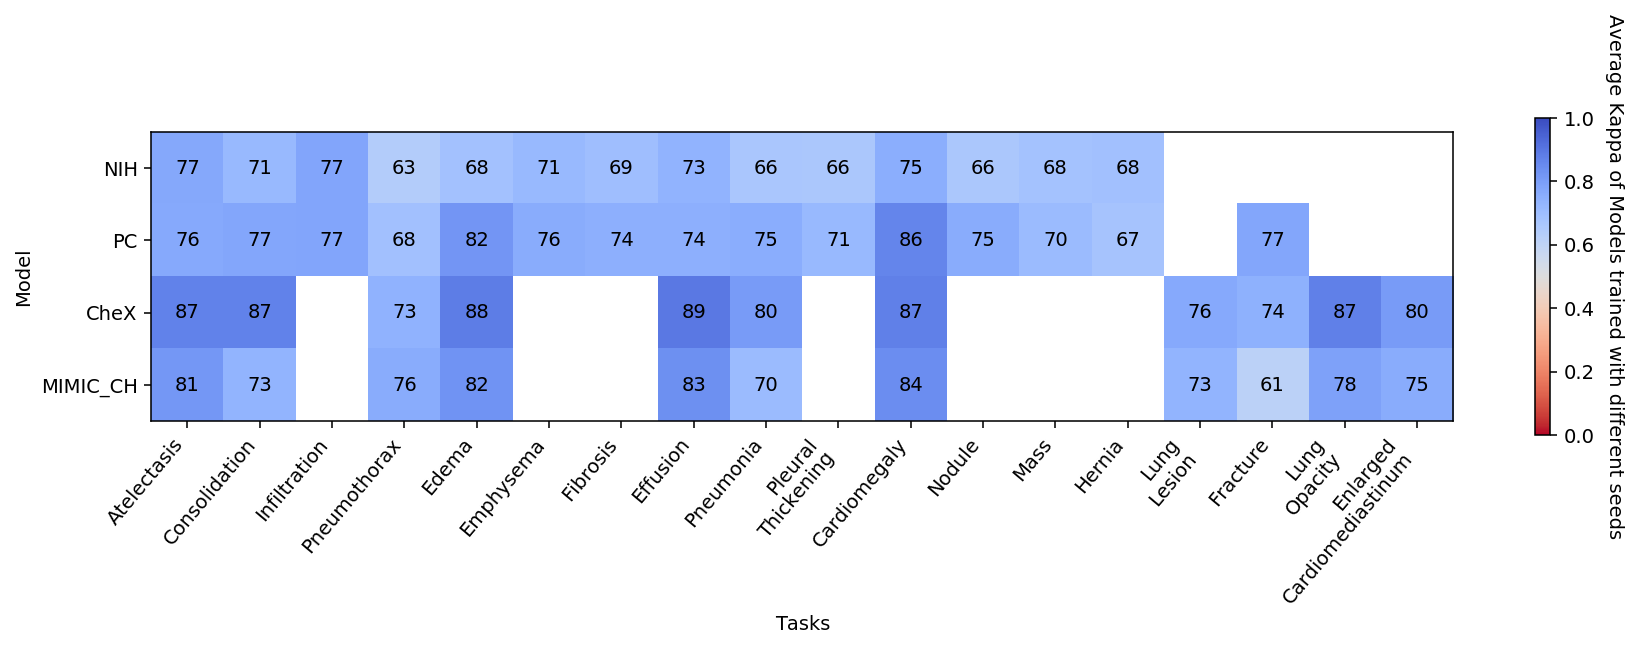

In [195]:
plt.figure(0, figsize=(15, 3), dpi=140)
im = plt.imshow(toplot, vmin=0, vmax=1, cmap="coolwarm_r");

pathos = [p.replace("_"," ").replace(" ","\n") for p in datasets.xray.default_pathologies]
plt.xticks(range(toplot.shape[1]),np.array(pathos),
           rotation='50',horizontalalignment="right");
plt.yticks(range(toplot.shape[0]),np.array(model_names));

cbar = plt.colorbar(im);
cbar.set_label('Average Kappa of Models trained with different seeds', rotation=270, labelpad=15)


x_start = -0.5
x_end = toplot.shape[1]-0.5
y_start = -0.5
y_end = toplot.shape[0]-0.5

# Add the text
jump_x = (x_end - x_start) / (2.0 * toplot.shape[1])
jump_y = (y_end - y_start) / (2.0 * toplot.shape[0])
x_positions = np.linspace(start=x_start, stop=x_end, num=toplot.shape[1], endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=toplot.shape[0], endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        if ~np.isnan(toplot[y_index, x_index]):
            label = str(int(toplot[y_index, x_index]*100))[:4]
            text_x = x + jump_x
            text_y = y + jump_y
            plt.text(text_x, text_y, label, color='black', ha='center', va='center')

plt.xlabel("Tasks");
plt.ylabel("Model");

In [90]:
import scipy.stats

In [181]:
model_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH']
dataset_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH']

In [184]:
kappa_all = {}
results_all = {}
for ii, testset_name in enumerate(dataset_names):
    results_all[testset_name] = {}
    for model_name in model_names:
        results_all[testset_name][model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

    # to avg over seeds
    results_all[testset_name] = get_avg_auc(results_all[testset_name])
    
    kappa_all[testset_name] = {}
    for model_name in model_names:
        kappas = []
        for i in range(len(datasets.xray.default_pathologies)):
            if len(results_all[testset_name][testset_name][0][3][i]) > 0:
                aa = op_thres(results_all[testset_name][testset_name][0][3][i], results_all[testset_name][testset_name][0][2][i])
                bb = op_thres(results_all[testset_name][model_name][0][3][i], results_all[testset_name][model_name][0][2][i])
                
                #k = 1-np.abs(aa-bb).mean()
                k = kappa(aa, bb)
#                 k = scipy.stats.kendalltau(results_all[testset_name][testset_name][0][2][i],
#                                           results_all[testset_name][model_name][0][2][i])
                
                kappas.append(k)
            else:
                kappas.append(np.nan)
        kappa_all[testset_name][model_name] = np.asarray(kappas)
        
        

In [206]:
toplot = np.zeros([len(dataset_names),len(datasets.xray.default_pathologies)])*np.nan
# y = test    x = task

for j, test in enumerate(dataset_names):
    for index, task in enumerate(np.asarray(datasets.xray.default_pathologies)[neworder]):
        
        taski = datasets.xray.default_pathologies.index(task)
        res = []
        for i,train in enumerate(model_names):
            if (train != test):
                if len(results_all[train][train][0][3][taski]) > 0:
                    r = kappa_all[test][train][taski]
                    res.append(r)
                    print(test,task,train, r)
                
        toplot[j,index] = np.mean(res)

NIH Hernia PC 0.24114878761701264
NIH Effusion PC 0.5568123666360881
NIH Effusion CheX 0.5102896516891409
NIH Effusion MIMIC_CH 0.45154100560859756
NIH Edema PC 0.4764624598478461
NIH Edema CheX 0.448992420044787
NIH Edema MIMIC_CH 0.27800371919416894
NIH Cardiomegaly PC 0.587087198052043
NIH Cardiomegaly CheX 0.297706958277328
NIH Cardiomegaly MIMIC_CH 0.20243680372205952
NIH Fibrosis PC 0.38869609796417753
NIH Mass PC 0.5715671655132
NIH Emphysema PC 0.33695222216315857
NIH Consolidation PC 0.5520982653325632
NIH Consolidation CheX 0.5367874165243793
NIH Consolidation MIMIC_CH 0.33800727389829527
NIH Lung Opacity CheX nan
NIH Lung Opacity MIMIC_CH nan
NIH Enlarged Cardiomediastinum CheX nan
NIH Enlarged Cardiomediastinum MIMIC_CH nan
NIH Atelectasis PC 0.6408623677053119
NIH Atelectasis CheX 0.5111843952397875
NIH Atelectasis MIMIC_CH 0.3963655629864867
NIH Pleural_Thickening PC 0.31994712779181356
NIH Pneumothorax PC 0.38974777029950314
NIH Pneumothorax CheX 0.29150926575106184
NIH 

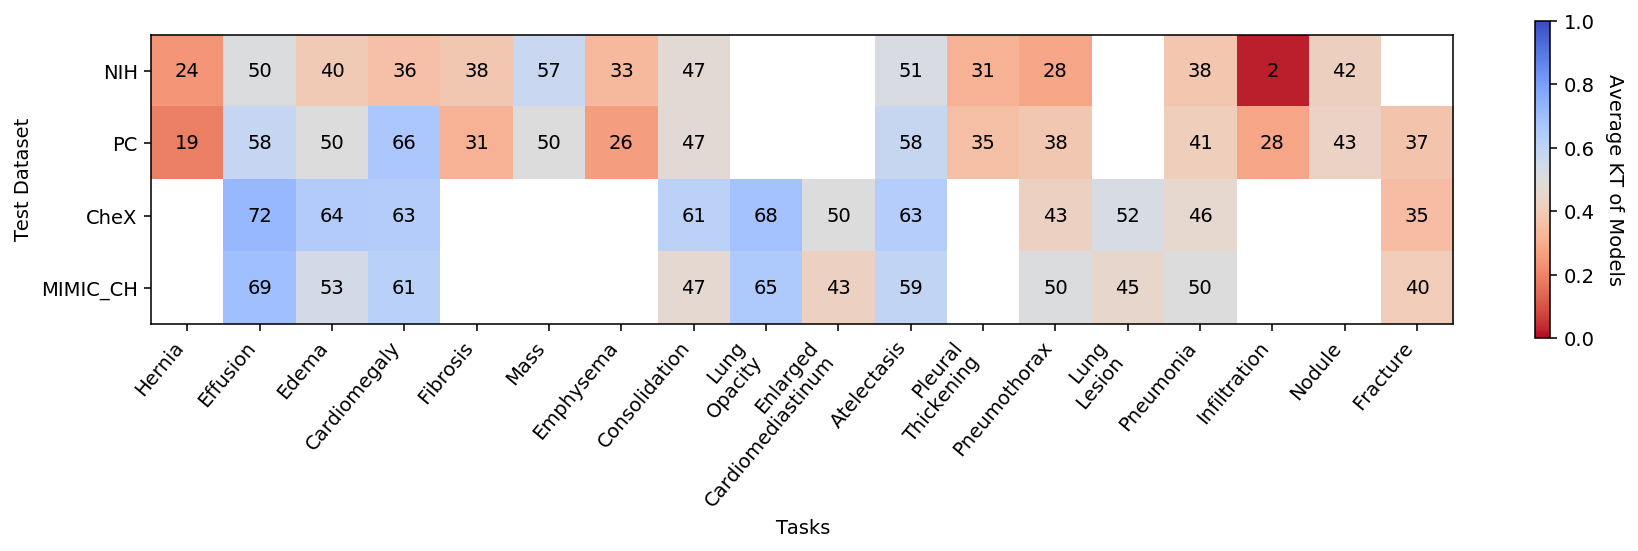

In [207]:
plt.figure(0, figsize=(15, 3), dpi=140)
im = plt.imshow(toplot, vmin=0, vmax=1, cmap="coolwarm_r");

pathos = [p.replace("_"," ").replace(" ","\n") for p in datasets.xray.default_pathologies]
plt.xticks(range(toplot.shape[1]),np.array(pathos)[neworder],
           rotation='50',horizontalalignment="right");
plt.yticks(range(toplot.shape[0]),np.array(model_names));

cbar = plt.colorbar(im);
cbar.set_label('Average KT of Models', rotation=270, labelpad=15)


x_start = -0.5
x_end = toplot.shape[1]-0.5
y_start = -0.5
y_end = toplot.shape[0]-0.5

# Add the text
jump_x = (x_end - x_start) / (2.0 * toplot.shape[1])
jump_y = (y_end - y_start) / (2.0 * toplot.shape[0])
x_positions = np.linspace(start=x_start, stop=x_end, num=toplot.shape[1], endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=toplot.shape[0], endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        if ~np.isnan(toplot[y_index, x_index]):
            label = str(int(toplot[y_index, x_index]*100))[:4]
            text_x = x + jump_x
            text_y = y + jump_y
            plt.text(text_x, text_y, label, color='black', ha='center', va='center')

plt.xlabel("Tasks");
plt.ylabel("Test Dataset");

In [180]:
for i,train in enumerate(model_names):
    if (train != "NIH"):
        print(kappa_all["NIH"][train][0])

1.0
1.0
1.0


KeyError: 'MIMIC_NB'

In [173]:
(np.nansum(datasetz["NIH"].labels, axis=0) > 0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False])

In [117]:
datasets.xray.default_pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [43]:
# find most confusing image of infiltration

In [39]:
model_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']
testset_name = "NIH"
results = {}
for model_name in model_names:
    results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))
#results = get_avg_auc(results)


In [40]:
#i = datasets.xray.default_pathologies.index("Fracture")
i = datasets.xray.default_pathologies.index("Hernia")
#i = datasets.xray.default_pathologies.index("Infiltration")
i

13

In [41]:
model1 = "NIH"
model2 = "PC"
aa = op_norm(results[model1][0][3][i], results[model1][0][2][i])
bb = op_norm(results[model2][0][3][i], results[model2][0][2][i])

0.00057393266
0.011241301


In [74]:
dif = bb

In [105]:
valid = np.where((aa > 0.50) & (bb < aa))[0]

In [106]:
has_label = np.where((results[testset_name][0][3][i] == 1))[0]

In [108]:
[e for e in np.argsort(dif) if e in has_label and e in valid]

[14950, 8667, 10540, 5430, 11204, 4786, 14153, 11642]

In [125]:
idx = 10540
print(model1, aa[idx])
print(model2, bb[idx])

NIH 0.5153952256240553
PC 0.17812268672037168


In [126]:
data = test_datasets[testset_name]
sample = data[idx]
sample

{'PA': array([[[-911.5608 , -903.5294 , -903.5294 , ..., -501.96075,
          -405.5843 , -895.49805],
         [-911.5608 , -887.4667 , -815.1843 , ..., -630.46277,
          -542.1177 , -927.62354],
         [-871.40393, -783.05884, -694.71375, ..., -766.9961 ,
          -702.7451 , -959.749  ],
         ...,
         [-895.49805, -895.49805, -895.49805, ..., -614.4    ,
          -485.898  , -911.5608 ],
         [-879.4353 , -879.4353 , -887.4667 , ..., -590.3059 ,
          -469.83527, -903.5294 ],
         [-887.4667 , -879.4353 , -887.4667 , ..., -622.4314 ,
          -518.02356, -919.59216]]], dtype=float32),
 'lab': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1., nan, nan, nan, nan]),
 'idx': 7886}

In [127]:
#datasetz[testset_name].csv.iloc[sample["idx"]].ImageID

In [128]:
datasetz[testset_name].csv.iloc[sample["idx"]]

Patient ID                                 7887
Image Index                    00007887_000.png
Finding Labels                           Hernia
Follow-up #                                   0
Patient Age                                079Y
Patient Gender                                M
View Position                                PA
OriginalImage[Width                        2500
Height]                                    2048
OriginalImagePixelSpacing[x               0.168
y]                                        0.168
Unnamed: 11                                 NaN
Name: 7886, dtype: object

{'Atelectasis': 0.0,
 'Consolidation': 0.0,
 'Infiltration': 0.0,
 'Pneumothorax': 0.0,
 'Edema': 0.0,
 'Emphysema': 0.0,
 'Fibrosis': 0.0,
 'Effusion': 0.0,
 'Pneumonia': 0.0,
 'Pleural_Thickening': 0.0,
 'Cardiomegaly': 0.0,
 'Nodule': 0.0,
 'Mass': 0.0,
 'Hernia': 1.0,
 'Lung Lesion': nan,
 'Fracture': nan,
 'Lung Opacity': nan,
 'Enlarged Cardiomediastinum': nan}

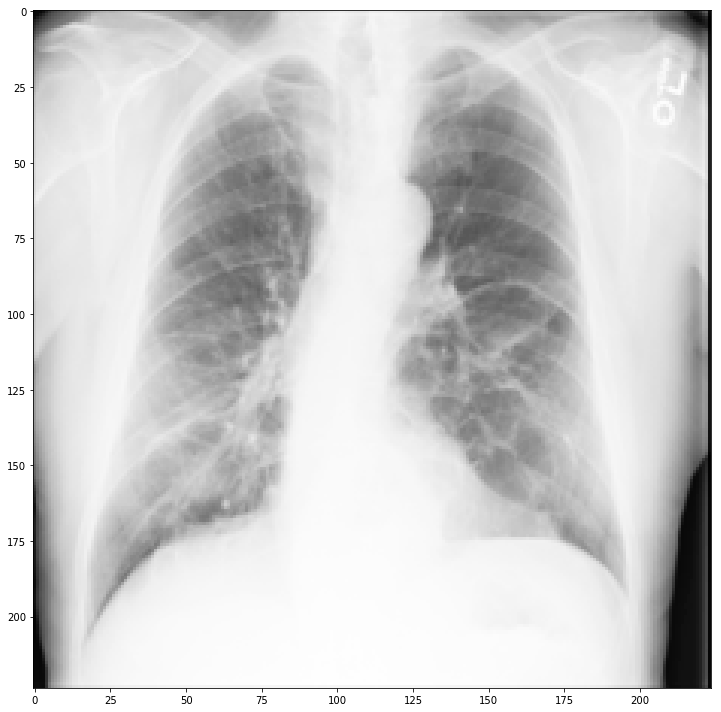

In [129]:
plt.figure(0, figsize=(10, 10))
plt.imshow(sample["PA"][0], cmap="Greys_r");
#plt.axis('off')
plt.tight_layout()
dict(zip(datasetz["NIH"].pathologies,sample["lab"]))

In [35]:
model1 = "MIMIC_CH"
model2 = "MIMIC_NB"
aa = op_norm(results[model1][0][3][i], results[model1][0][2][i])
bb = op_norm(results[model2][0][3][i], results[model2][0][2][i])

0.038236365
0.017476916


In [36]:
valid = np.where((bb > 0.51))[0]

In [37]:
dif = aa

In [38]:
np.argsort(dif)[:10]

array([ 1214,  3370,   928, 11748,  6051,  7539,  6405, 15338,  5467,
         194])

In [39]:
#results[testset_name][0][3]

In [40]:
has_label = np.where((results[testset_name][0][3][i] == 1))[0]

In [121]:
#has_label

In [41]:
[e for e in np.argsort(dif)[:10000] if e in has_label and e in valid]

[13167, 3554, 5333]

In [101]:
#set(np.argsort(dif)[:13000]).intersection(has_label).intersection(valid)

In [110]:
idx = 12

In [250]:
mismatches = [aa[idx] - bb[idx] for idx in mismatch]

In [251]:
sorted(mismatches)[:3]

[-0.46318579231562923, -0.3817889304821215, -0.3605118064484369]

In [252]:
np.asarray(mismatch)[np.argsort(mismatches)]

array([15100, 11736,  9418, 13617,  6872,  7925,  9487,  5232,  1819,
        3741, 11965, 14714,  7612,  1997, 10783, 15397,  7360,  3373,
       14198,  3084, 14049,  4775,  2712, 15672, 12455, 14780, 11452,
        6193,  3920, 14683,  1132,  8367,  8647, 15535, 15652, 15961,
       12402,  2081,   160,  7675,  8661, 10653,  8492, 13460,  3456,
       15912,   856,  1802,  4719,  7156,  5220,  7195, 15228, 11737,
         693,  1666,  2934, 16153,  9235,  8978,  4905, 12156,  2977,
       14525,  1371,  4871,  7895, 16211,  6498,  8555, 15310, 10816,
        2198, 12721, 10664,   158,  5132,  4658, 13812,  8481, 16411,
        9869, 14591,  3558,   290,  3590,  5897,  4264,  5378, 16020,
         606,    12, 13008, 15414, 10952, 12692,  2155,   597,  4665,
        5060, 12759, 12764,  6441, 10667,  7193,  9463, 12404,  5096,
        2072, 11073,   739,  3927, 15576, 10014,  4040,  1900, 11559,
       14956,  7246,  4515, 12073,  6799,  1545,  1419, 10235,  7259,
        8386,  5721,

In [265]:
idx = 3319
print(model1, aa[idx])
print(model2, bb[idx])

MIMIC_CH 0.5011900986267033
MIMIC_NB 0.08231128224607283


In [233]:
#[results[testset_name][0][3][k][690] if len(results["NIH"][0][3][k])>0 else np.nan for k in range(18)]

In [85]:
idx_for_results = np.where(~np.isnan(test_datasets[testset_name].labels[:,i]))[0]

In [199]:
#list(idx_for_results).index(15)

In [266]:
data = test_datasets[testset_name]
sample = data[idx_for_results[idx]]
sample

{'PA': array([[[1024., 1024., 1024., ..., 1024., 1024., 1024.],
         [1024., 1024., 1024., ..., 1024., 1024., 1024.],
         [1024., 1024., 1024., ..., 1024., 1024., 1024.],
         ...,
         [1024., 1024., 1024., ..., 1024., 1024., 1024.],
         [1024., 1024., 1024., ..., 1024., 1024., 1024.],
         [1024., 1024., 1024., ..., 1024., 1024., 1024.]]], dtype=float32),
 'lab': array([nan, nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan,  0., nan, nan]),
 'idx': 2660,
 'img_path': '/lustre04/scratch/cohenjos/MIMIC/images-224/files/p10/p10588630/s52993538/574d988c-fc8b10ea-ed2a4270-9e90be70-dcd274a8.jpg'}

In [267]:
#datasetz[testset_name].csv.iloc[sample["idx"]].ImageID

In [268]:
datasetz["MIMIC_NB"].csv.iloc[sample["idx"]].Fracture

0.0

In [269]:
datasetz["MIMIC_CH"].csv.iloc[sample["idx"]].Fracture

1.0

In [248]:
h = test_datasets["MIMIC_NB"].labels[:,i]
k = test_datasets["MIMIC_CH"].labels[:,i]
a = ~np.isnan(h) & ~np.isnan(k) & (h != k)

In [239]:
a.shape

(22814,)

In [240]:
a[~np.isnan(h)].shape

(16495,)

In [241]:
np.where(a)[0][:10]

array([11737])

In [249]:
mismatch = [list(idx_for_results).index(p) for p in np.where(a)[0]]

In [89]:
results[model1][0][3][i].shape

(16495,)

In [ ]:
idx_for_results

{'Atelectasis': nan,
 'Consolidation': nan,
 'Infiltration': nan,
 'Pneumothorax': 0.0,
 'Edema': nan,
 'Emphysema': nan,
 'Fibrosis': nan,
 'Effusion': nan,
 'Pneumonia': nan,
 'Pleural_Thickening': nan,
 'Cardiomegaly': nan,
 'Nodule': nan,
 'Mass': nan,
 'Hernia': nan,
 'Lung Lesion': nan,
 'Fracture': 0.0,
 'Lung Opacity': nan,
 'Enlarged Cardiomediastinum': nan}

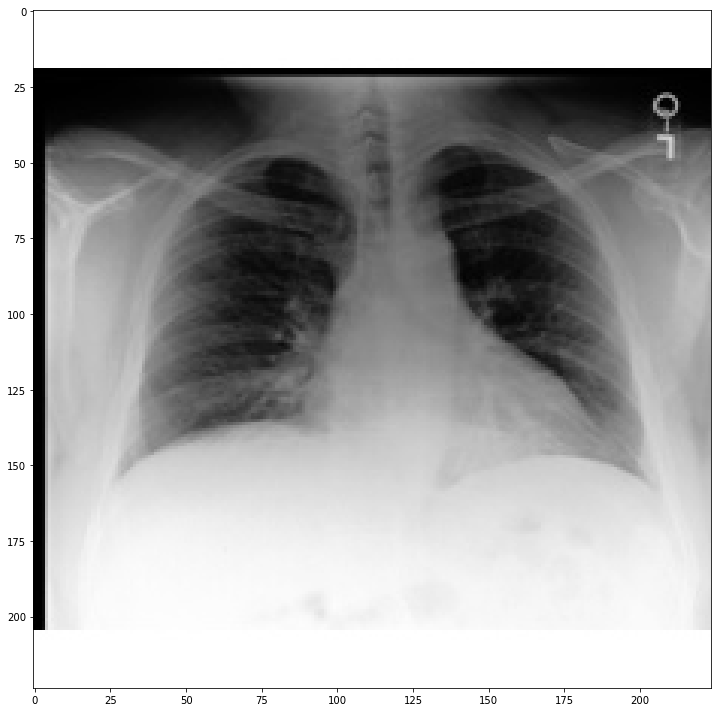

In [270]:
plt.figure(0, figsize=(10, 10))
plt.imshow(sample["PA"][0], cmap="Greys_r");
#plt.axis('off')
plt.tight_layout()
dict(zip(datasetz["NIH"].pathologies,sample["lab"]))

In [644]:
#!ls /home/cohenjos/scratch/concept-embedding2/*best*

In [539]:
model_dataset = "NIH"
model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt".format(model_dataset.lower()))


In [540]:
out = model(torch.from_numpy(sample["PA"]).unsqueeze(0).cuda()).cpu().detach().numpy()
dict(zip(datasets.xray.default_pathologies,out[0]))

{'Atelectasis': -7.080826,
 'Consolidation': -7.4737296,
 'Infiltration': -4.265093,
 'Pneumothorax': -6.6039,
 'Edema': -16.142147,
 'Emphysema': -8.028293,
 'Fibrosis': -6.515723,
 'Effusion': -6.911163,
 'Pneumonia': -7.3543677,
 'Pleural_Thickening': -6.902209,
 'Cardiomegaly': -12.806189,
 'Nodule': -4.398216,
 'Mass': -5.7025094,
 'Hernia': -8.529287,
 'Lung Lesion': 2.796556e-39,
 'Fracture': 2.076902e-39,
 'Lung Opacity': 6.362776e-39,
 'Enlarged Cardiomediastinum': -1.248948e-39}

In [32]:
# i=0
# aa = op_thres(results["NIH"][3][i], results["NIH"][2][i])

In [93]:
# aaa = op_norm(results["NIH"][3][i], results["NIH"][2][i])

In [69]:
# torch.sigmoid_(torch.from_numpy(results[model1][0][2][0])).numpy()

In [94]:
#Bland–Altman

Atelectasis
 TestData:NIH (N=15403, T=866)
0.6408623677053119


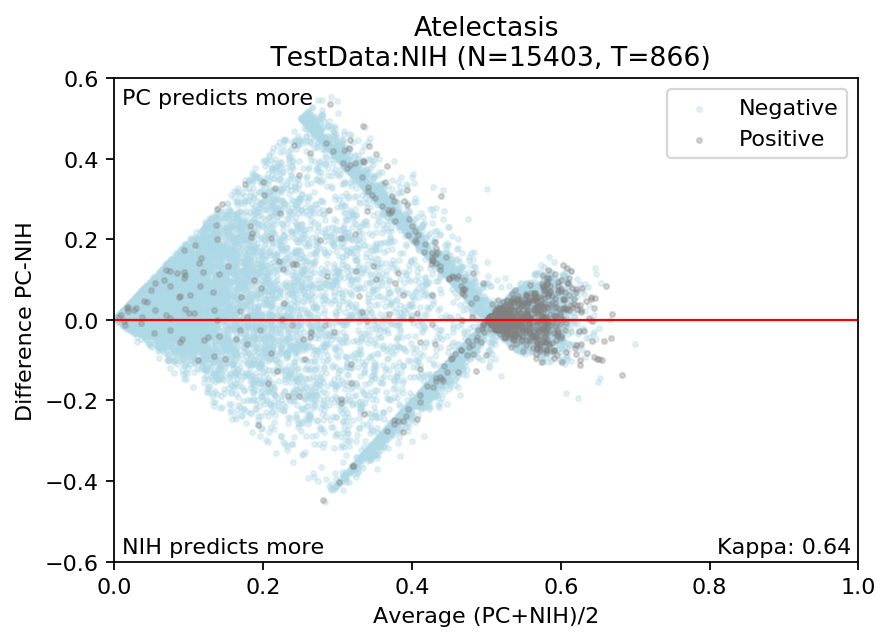

Consolidation
 TestData:NIH (N=15403, T=203)
0.5520982653325632


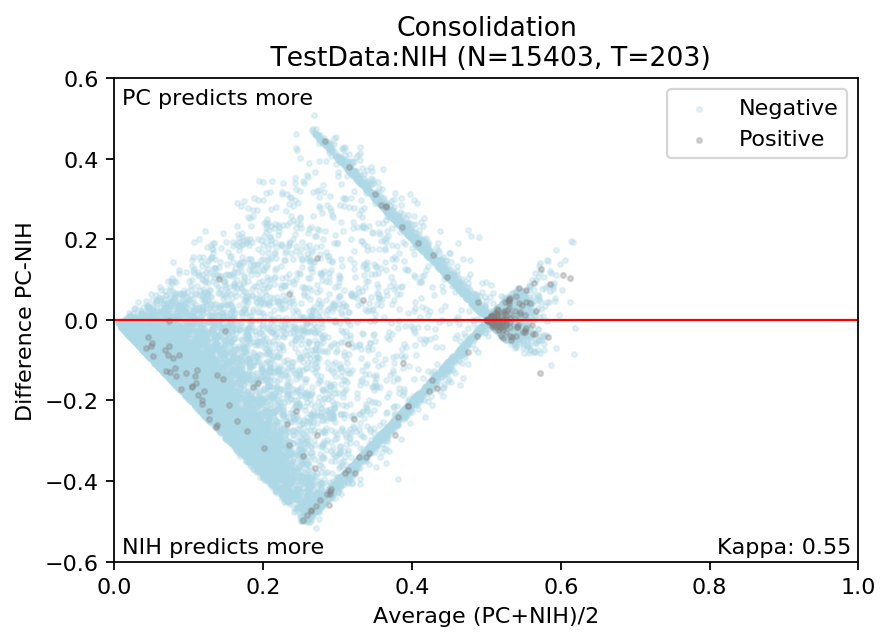

Infiltration
 TestData:NIH (N=15403, T=1809)
0.026700929052761408


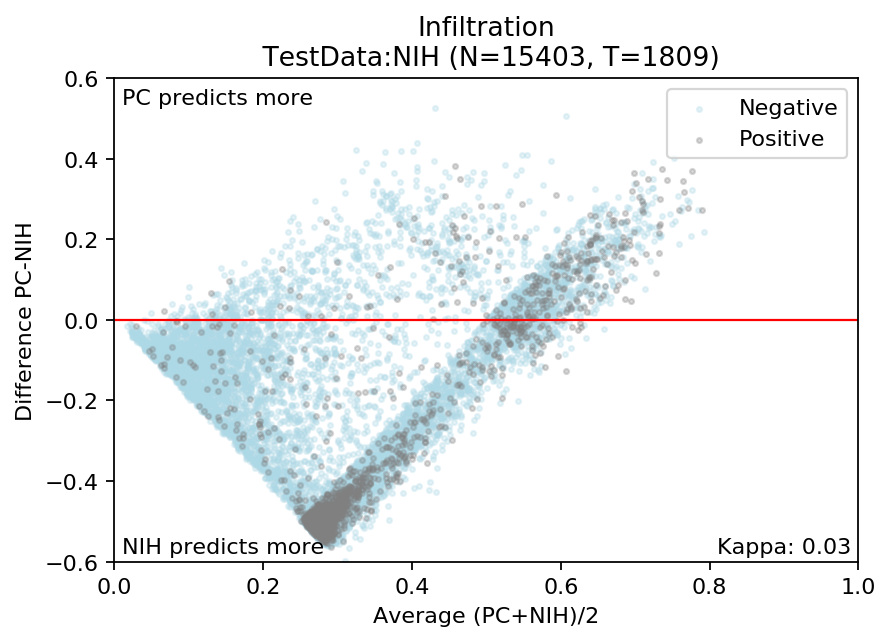

Pneumothorax
 TestData:NIH (N=15403, T=136)
0.38974777029950314


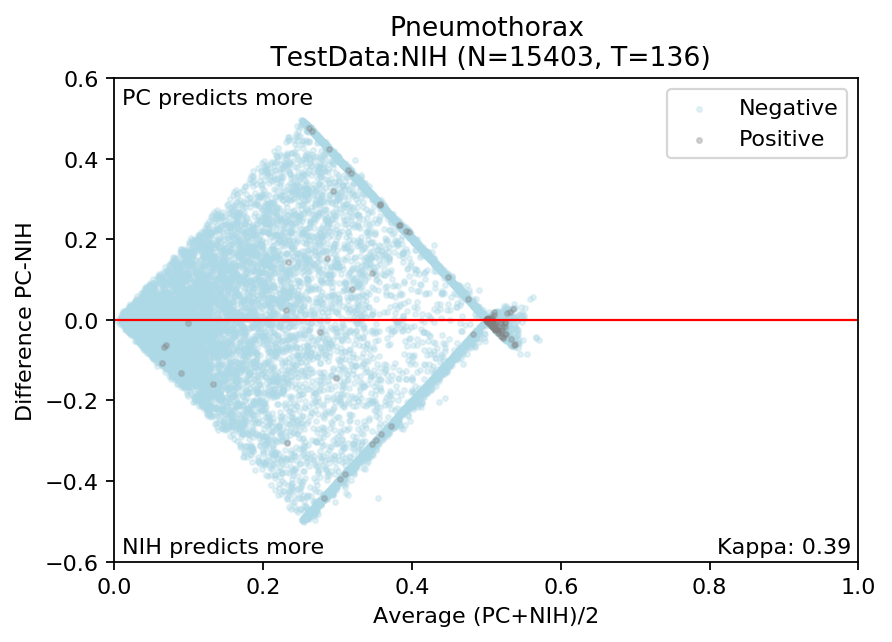

Edema
 TestData:NIH (N=15403, T=41)
0.4764624598478461


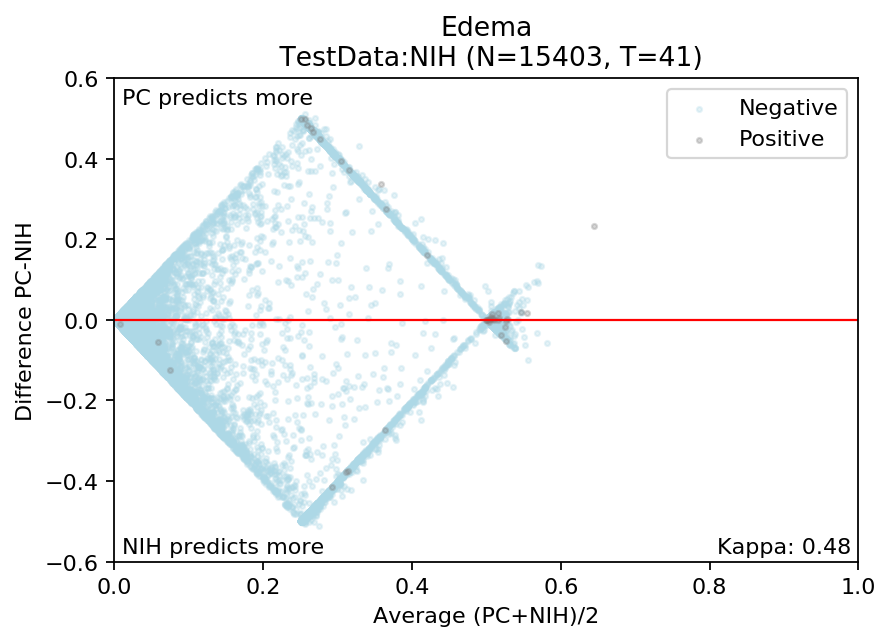

Emphysema
 TestData:NIH (N=15403, T=126)
0.33695222216315857


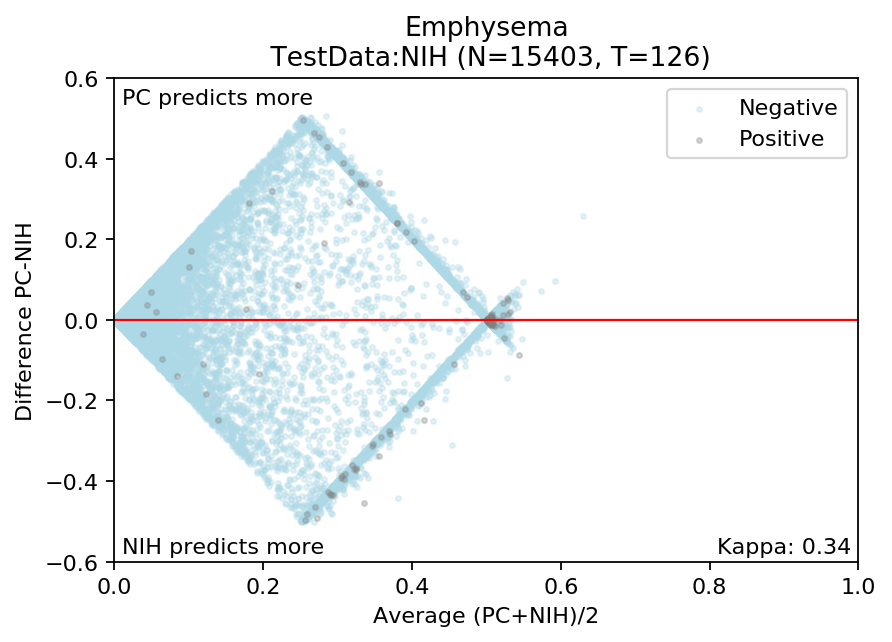

Fibrosis
 TestData:NIH (N=15403, T=292)
0.38869609796417753


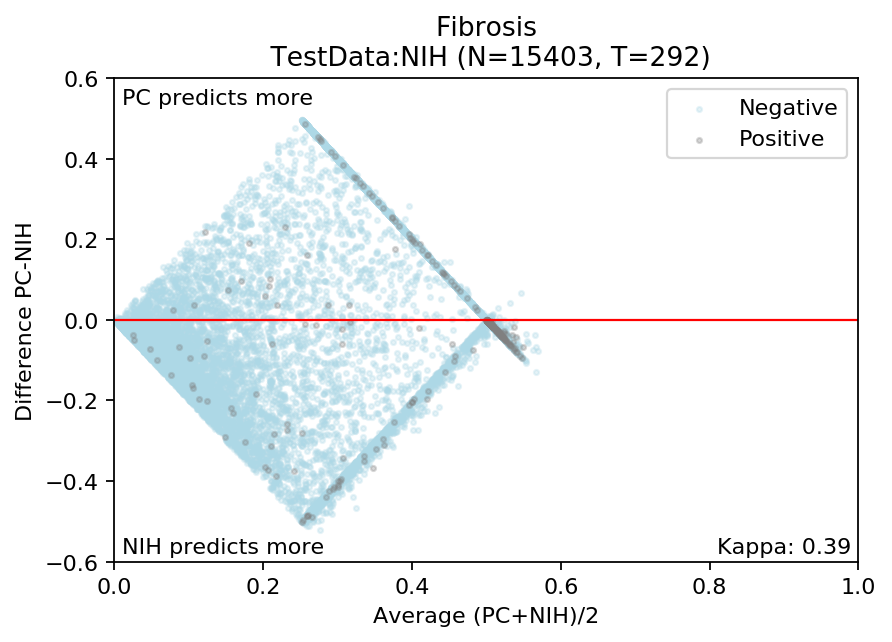

Effusion
 TestData:NIH (N=15403, T=656)
0.5568123666360881


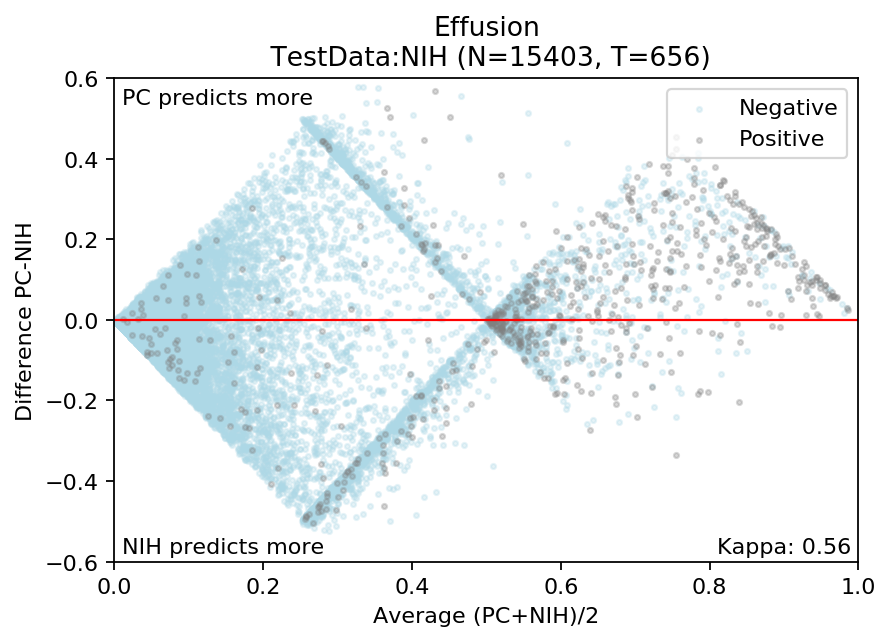

Pneumonia
 TestData:NIH (N=15403, T=87)
0.42025358315827316


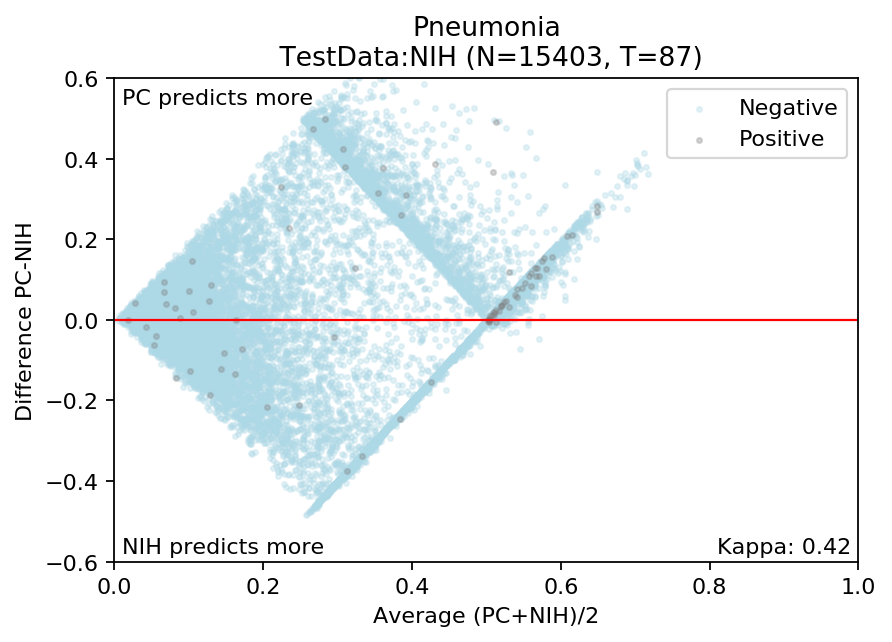

Pleural_Thickening
 TestData:NIH (N=15403, T=379)
0.31994712779181356


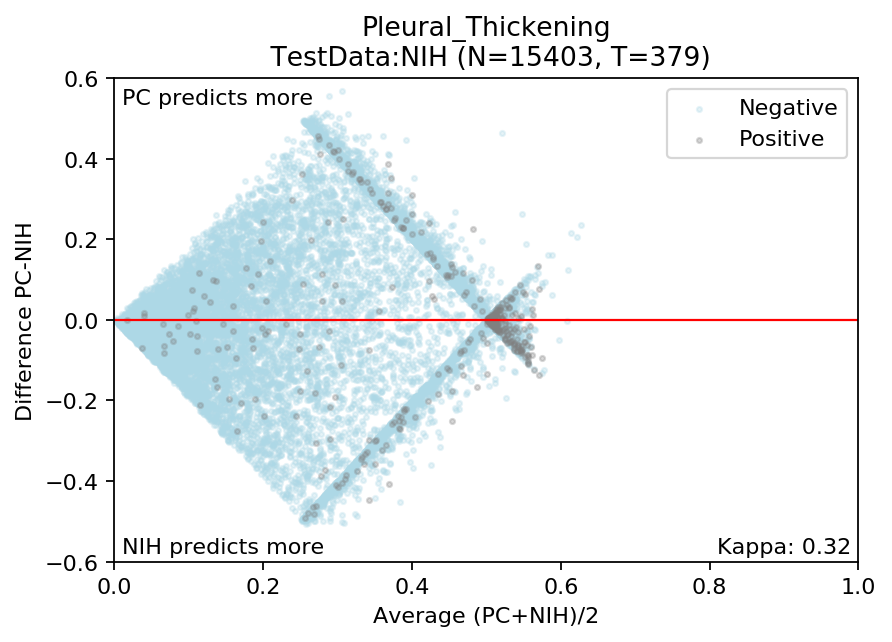

Cardiomegaly
 TestData:NIH (N=15403, T=399)
0.587087198052043


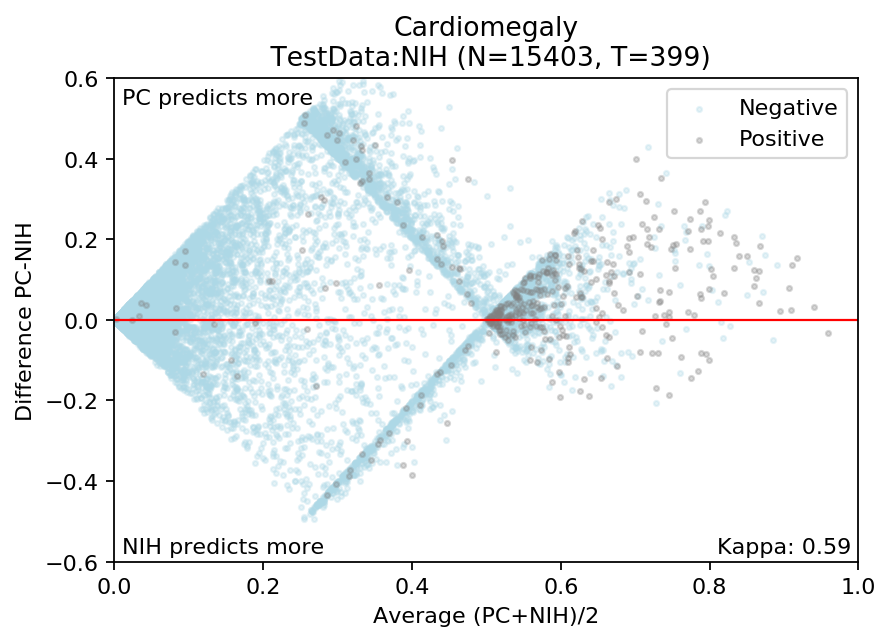

Nodule
 TestData:NIH (N=15403, T=806)
0.4253944840677223


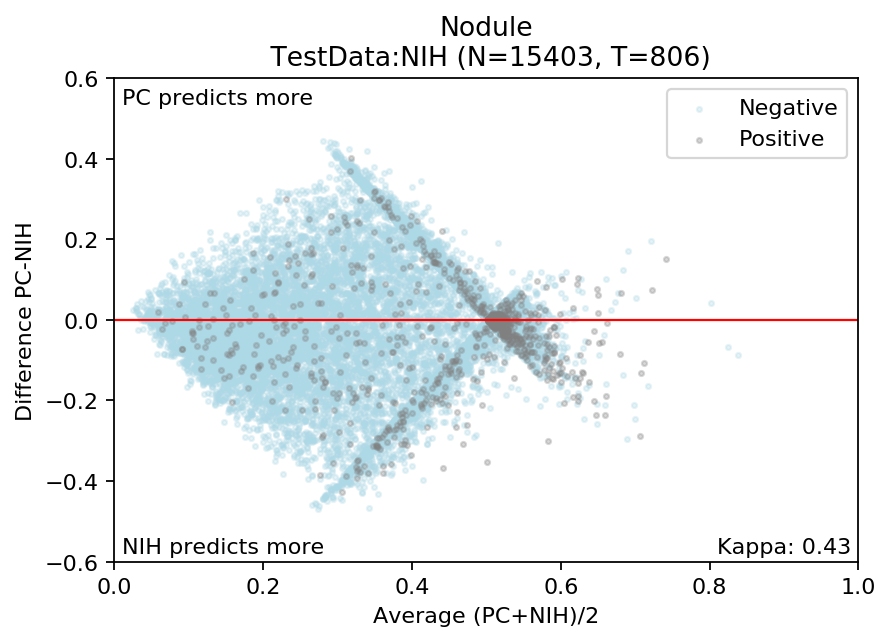

Mass
 TestData:NIH (N=15403, T=614)
0.5715671655132


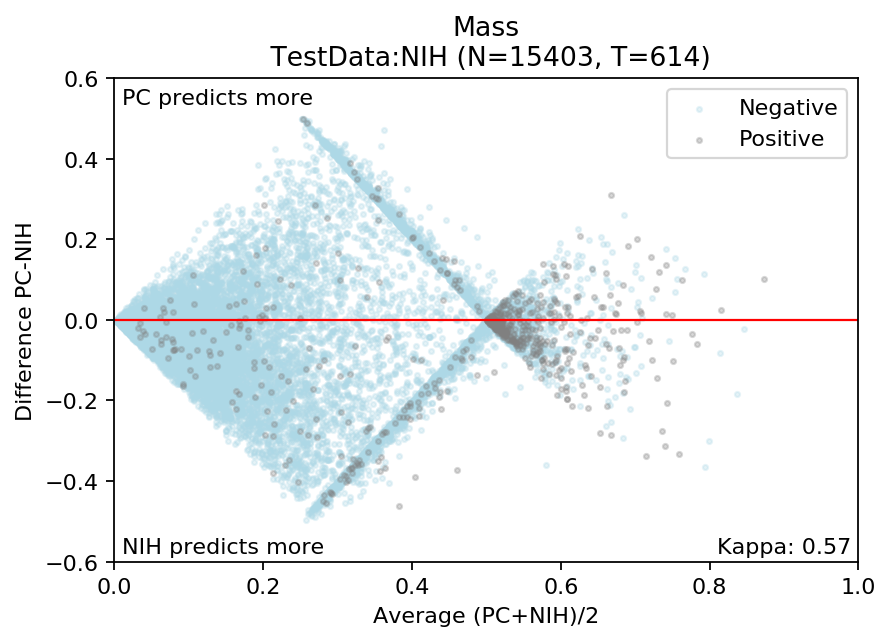

Hernia
 TestData:NIH (N=15403, T=39)
0.24114878761701264


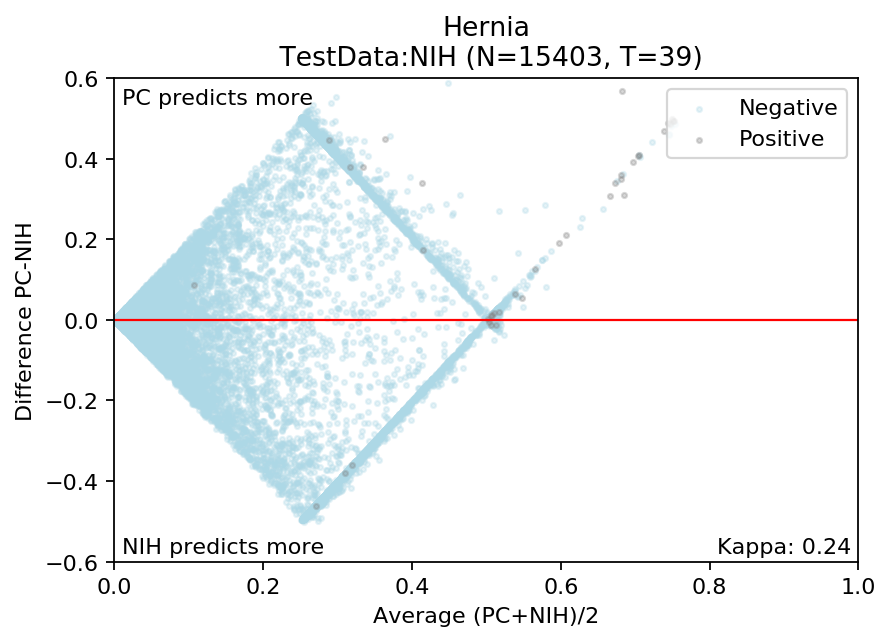

Lung Lesion
 TestData:NIH (N=0, T=0)
Fracture
 TestData:NIH (N=0, T=0)
Lung Opacity
 TestData:NIH (N=0, T=0)
Enlarged Cardiomediastinum
 TestData:NIH (N=0, T=0)


In [197]:
testset_name = "NIH"

results = {}
for model_name in model_names:
    results[model_name] = pickle.load(open("results-da-new-seeds-ts{}-m{}.pkl".format(testset_name, model_name), "br"))

# to avg over seeds
results = get_avg_auc(results)

model1 = "PC"
model2 = "NIH"

pathos = []
counts = (~np.isnan(test_datasets[testset_name].labels)).sum(0)
countsT = np.nansum(test_datasets[testset_name].labels, axis=0)
for i, patho in enumerate(np.array(datasets.xray.default_pathologies)):
    pathos.append(patho + "\n TestData:{} (N={}, T={})".format(testset_name, int(counts[i]),int(countsT[i])))

for i, patho in enumerate(np.array(datasets.xray.default_pathologies)):
    #aa = results["NIH"][2][i]
    print(pathos[i]);
    if counts[i] == 0:
        continue
    #aa = torch.sigmoid_(torch.from_numpy(results[model1][0][2][i])).numpy()
    aa = op_norm(results[model1][0][3][i], results[model1][0][2][i])
    #bb = torch.sigmoid_(torch.from_numpy(results[model2][0][2][i])).numpy()
    bb = op_norm(results[model2][0][3][i], results[model2][0][2][i])
    y = aa-bb
    x = (aa+bb)/2
    
    
    aaa = op_thres(results[model1][0][3][i], results[model1][0][2][i])
    bbb = op_thres(results[model2][0][3][i], results[model2][0][2][i])

    k = kappa(aaa,bbb)
    print(k)
    
    f, ax = plt.subplots(1, figsize = (6,4), dpi=160)
    #statsmodels.graphics.mean_diff_plot(aa, bb, ax = ax)
    #plt.title(datasetz["NIH"].pathologies[i])
    #plt.show()
    t = results["NIH"][0][3][i] == 1
    plt.scatter(x=x[~t],y=y[~t], c="lightblue",s=5, alpha=0.3, label="Negative")
    plt.scatter(x=x[t],y=y[t], c="gray",s=5, alpha=0.3, label="Positive")
            
    plt.axhline(linewidth=1, color='r');
    plt.title(pathos[i]);
    plt.xlabel("Average ({}+{})/2".format(model1,model2));
    plt.ylabel("Difference {}-{}".format(model1,model2));
    plt.legend(loc="upper right");
    plt.text(0.01, 0.01,'{} predicts more'.format(model2),
         horizontalalignment='left',
         verticalalignment='bottom',
         transform = ax.transAxes)
    plt.text(0.01, 0.98,'{} predicts more'.format(model1),
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)
    
    plt.text(0.99, 0.01,'Kappa: {:.2f}'.format(k),
         horizontalalignment='right',
         verticalalignment='bottom',
         transform = ax.transAxes)
    
    plt.ylim(-0.6,0.6)
    plt.xlim(0,1)
    plt.show();
#     if i ==1:
#         break
        

In [ ]:
# for each model run images from each dataset
# take the output layer and plot it

In [43]:
!ls /home/cohenjos/scratch/concept-embedding2/*best*

/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_ch-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/mimic_nb-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-

In [26]:
# results2 = {}
# model = torch.load("/home/cohenjos/scratch/concept-embedding2/NIH_XrayDataset-densenet121-d121-tw-lr001-best.pt")
# # for dataset_name in dataset_names:
    
# #     results2[dataset_name] = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loaders[dataset_name], torch.nn.BCEWithLogitsLoss(), limit=60)


In [93]:
#!nvidia-smi

In [12]:
# torch.cuda.empty_cache()

In [14]:
# d = next(iter(test_loaders["NIH"]))

In [55]:
# outputs = []
# labels = []
# origin = []
# for i, batch in enumerate(test_loaders["NIH"]):
#     print(i)
#     if i > 50: 
#         break;
#     with torch.no_grad():
#         out = model(batch["PA"].cuda())
#         #out = model.features(batch["PA"].cuda())
#         outputs.append(out.detach().cpu().numpy())
#         labels.append(batch["lab"].cpu().numpy())
#         origin.append([0]*cfg.batch_size)

In [56]:
# outputs = np.concatenate(outputs)
# labels = np.concatenate(labels)
# origin = np.concatenate(origin)

In [70]:
import torch.nn.functional as F
def extract(testset_name, thismodel, originid, limit=3000):
    outputs = []
    labels = []
    origin = []
    for i, batch in enumerate(test_loaders[testset_name]):
        print(i)
        if i > limit: 
            break;
        with torch.no_grad():
            #out = model(batch["PA"].cuda())
            out = thismodel.features(batch["PA"].cuda())
            out = F.relu(out, inplace=True)
            out = F.adaptive_avg_pool2d(out, (1, 1))
            #print(out.shape)
            outputs.append(out.detach().cpu().numpy())
            labels.append(batch["lab"].cpu().numpy())
            origin.append([originid]*batch["lab"].cpu().numpy().shape[0])
            
    return merge(outputs, labels, origin)
            
def merge(outputs, labels, origin):
    outputs = np.concatenate(outputs)
    outputs = outputs.reshape(outputs.shape[0], -1)

    labels = np.concatenate(labels)
    origin = np.concatenate(origin)
    
    return outputs, labels, origin
#model = model.cuda();

In [181]:
!ls /home/cohenjos/scratch/concept-embedding2/*best.pt

/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt
/home/cohenjos/scratch/concept-embedding2/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr001-rot45-tr15-sc15-best.pt
/home/cohenjos/scratch/concept-embedding2/CheX_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr0001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr001-best.pt
/home/cohenjos/scratch/concept-embedding2/Merge_XrayDataset-densenet121-d121-tw-lr01-best.pt
/home/cohenjos/scratc

In [182]:
model_names = ['nihpcchexmimic_chmimic_nbgoogle']#['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB']

In [183]:
testset_names

['NIH', 'PC', 'CheX', 'NIH_Google', 'MIMIC_CH', 'MIMIC_NB']

In [71]:
# for model_name in model_names:
#     features = {}
#     for i, testset_name in enumerate(testset_names):
#         print(model_name, testset_name)
#         model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt".format(model_name.lower()))
#         features[testset_name] = extract(testset_name, model, i)
#         pickle.dump(features[testset_name], open("features-m{}-ts{}.pkl".format(model_name, testset_name), "bw"))
        
        

In [21]:
# features = {}
# features["NIH"] = extract("NIH", 0)
# import pickle
# pickle.dump(features["NIH"], open("features-mNIH-tsNIH.pkl", "bw"))
# features["PC"] = extract("PC", 1)
# pickle.dump(features["PC"], open("features-mNIH-tsPC.pkl", "bw"))
# features["CheX"] = extract("CheX", 2)
# pickle.dump(features["CheX"], open("features-mNIH-tsCheX.pkl", "bw"))

In [27]:
# dm = dm1
# dm = dm/np.nanmax(dm)
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if i<j:
#             dm[i,j] = np.nan

# # valid = np.nansum(datasetz[this_model].labels, axis=0) > 0
# # for i in np.arange(0,18):
# #     for j in np.arange(0,18):
# #         if ~valid[i] or ~valid[j]:
# #             dm[i,j] = np.nan

# dm = dm/np.nanmax(dm)
# dm = 1-dm

# plt.figure(0, figsize=(7, 7), dpi=100)
# plt.imshow(dm);
# plt.xticks(range(18),np.array(datasets.xray.default_pathologies),
#            rotation='40',horizontalalignment="right");
# plt.yticks(range(18),np.array(datasets.xray.default_pathologies));

# size = 18
# x_start = -0.5
# x_end = size-0.5
# y_start = -0.5
# y_end = size-0.5

# # Add the text
# jump_x = (x_end - x_start) / (2.0 * size)
# jump_y = (y_end - y_start) / (2.0 * size)
# x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
# y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

# for y_index, y in enumerate(y_positions):
#     for x_index, x in enumerate(x_positions):
#         if ~np.isnan(dm[y_index, x_index]):
#             label = str(int(dm[y_index, x_index]*100))[:4]
#             text_x = x + jump_x
#             text_y = y + jump_y
#             plt.text(text_x, text_y, label, color='black', ha='center', va='center')
# plt.title("Similarity between mean class features on {} dataset using {} model.".format(a_dataset, this_model));


In [28]:
# dm = dm2
# dm = dm/np.nanmax(dm)
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if i<j:
#             dm[i,j] = np.nan

# valid = np.nansum(datasetz[this_model].labels, axis=0) > 0
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if ~valid[i] or ~valid[j]:
#             dm[i,j] = np.nan

# dm = dm/np.nanmax(dm)
# dm = 1-dm

# plt.figure(0, figsize=(7, 7), dpi=100)
# plt.imshow(dm);
# plt.xticks(range(18),np.array(datasets.xray.default_pathologies),
#            rotation='40',horizontalalignment="right");
# plt.yticks(range(18),np.array(datasets.xray.default_pathologies));

# size = 18
# x_start = -0.5
# x_end = size-0.5
# y_start = -0.5
# y_end = size-0.5

# # Add the text
# jump_x = (x_end - x_start) / (2.0 * size)
# jump_y = (y_end - y_start) / (2.0 * size)
# x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
# y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

# for y_index, y in enumerate(y_positions):
#     for x_index, x in enumerate(x_positions):
#         if ~np.isnan(dm[y_index, x_index]):
#             label = str(int(dm[y_index, x_index]*100))[:4]
#             text_x = x + jump_x
#             text_y = y + jump_y
#             plt.text(text_x, text_y, label, color='black', ha='center', va='center')
# plt.title("Similarity between mean class features on {} dataset using {} model.".format(b_dataset, this_model));


In [84]:
# features = {}
# features["NIH"] = pickle.load(open("features-m{}-ts{}.pkl".format("NIH", "NIH"), "br"))
# features["NIH"][1].shape

In [65]:
import sklearn.metrics.pairwise

def get_feat_dist(testset_name, this_model):
    features = {}
    #for model_name in model_names:
    features[this_model] = pickle.load(open("features-m{}-ts{}.pkl".format(this_model, testset_name), "br"))
        
    subfeats = []
    for i in range(18):
        vecs = features[this_model][0][features[this_model][1][:,i] == 1]
        if vecs.shape[0] == 0:
            vecs = np.zeros([1,vecs.shape[1]])*np.nan
        subfeats.append(vecs.mean(0))
    subfeats = np.array(subfeats)
    
    notnan = ~np.isnan(subfeats.mean(1))
    # real dist 
    d = sklearn.metrics.pairwise_distances(subfeats[notnan], metric="l2")
    
#     # full dist
#     dd = np.zeros([subfeats.shape[0], subfeats.shape[0]])*np.nan
    
#     #integrate smaller into larger dist
#     ii = 0
#     for i, x in enumerate(~np.isnan(subfeats.mean(1))):
#         jj = 0
#         for j, y in enumerate(~np.isnan(subfeats.mean(1))):
#             if x and y:
#                 dd[i,j] = d[ii,jj]
#                 jj += 1
#         if x:
#             ii += 1

    return d


In [66]:
# for i in np.arange(0,18):
#     for j in np.arange(0,18):
#         if ~valid[i] or ~valid[j]:
#             dm[i,j] = np.nan

In [69]:
# this_model = "NIH"
# a_dataset = "PC"
# b_dataset = "NIH"

this_model = "MIMIC_CH"
a_dataset = "MIMIC_CH"
b_dataset = "MIMIC_NB"

def process_dm(dm):
    #dm = dm/np.nanmax(dm)
    for i in np.arange(0,dm.shape[0]):
        for j in np.arange(0,dm.shape[1]):
            if i<j:
                dm[i,j] = np.nan
    return dm#/np.nanmax(dm)

dm1 = get_feat_dist(testset_name=a_dataset, this_model=this_model)
dm2 = get_feat_dist(testset_name=b_dataset, this_model=this_model)




dm1 = process_dm(dm1)
dm1 /= np.nanmax(dm1)
dm2 = process_dm(dm2)
dm2 /= np.nanmax(dm2)

dm = np.abs(dm1 - dm2)

dm = process_dm(dm)


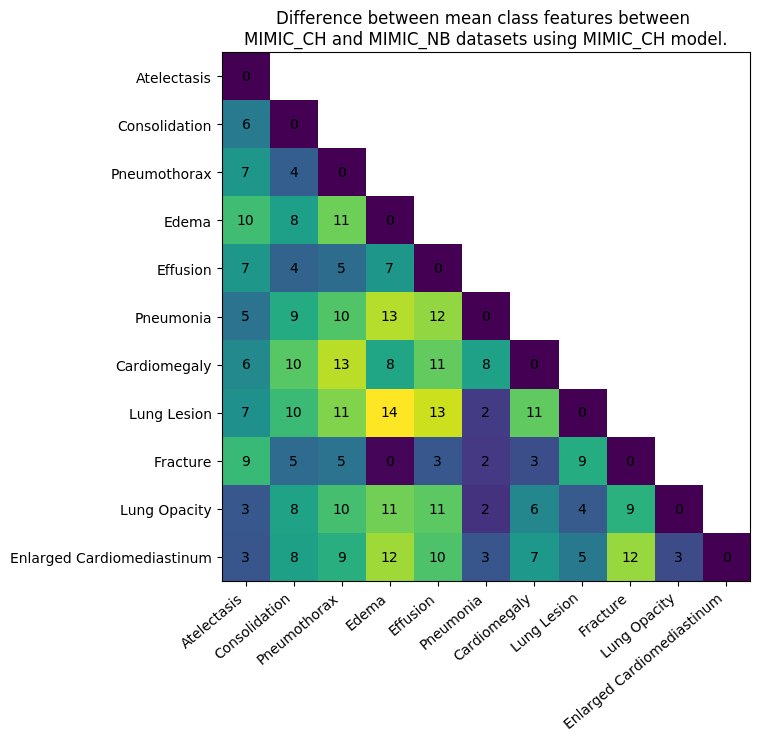

In [70]:
plt.figure(0, figsize=(7, 7), dpi=100)
plt.imshow(dm);
valid = np.nansum(datasetz[this_model].labels, axis=0) > 0

size = valid.sum()
#size=14

plt.xticks(range(size),np.array(datasets.xray.default_pathologies)[valid],
           rotation='40',horizontalalignment="right");
plt.yticks(range(size),np.array(datasets.xray.default_pathologies)[valid]);

x_start = -0.5
x_end = size-0.5
y_start = -0.5
y_end = size-0.5

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        if ~np.isnan(dm[y_index, x_index]):
            label = str(int(dm[y_index, x_index]*100))[:4]
            text_x = x + jump_x
            text_y = y + jump_y
            plt.text(text_x, text_y, label, color='black', ha='center', va='center')
plt.title("Difference between mean class features between \n{} and {} datasets using {} model.".format(a_dataset, b_dataset, this_model));


In [71]:
# pathologies = datasets.xray.default_pathologies
# neworder = ['Pneumothorax',
#             'Effusion',
#             'Atelectasis',
#              'Edema',
#              'Fracture',
#              'Lung Opacity',
#              'Lung Lesion',
#              'Cardiomegaly',
#              'Enlarged Cardiomediastinum',
#              'Emphysema',
#              'Fibrosis',
#              'Pleural_Thickening',
#              'Nodule',
#              'Mass',
#              'Hernia',
#             'Pneumonia',
#             'Consolidation',
#             'Infiltration',]
# neworder_idx = [pathologies.index(path) for path in neworder]

In [72]:
pathos = [path.replace("Cardiomediastinum", "Cardio") for path in datasets.xray.default_pathologies]

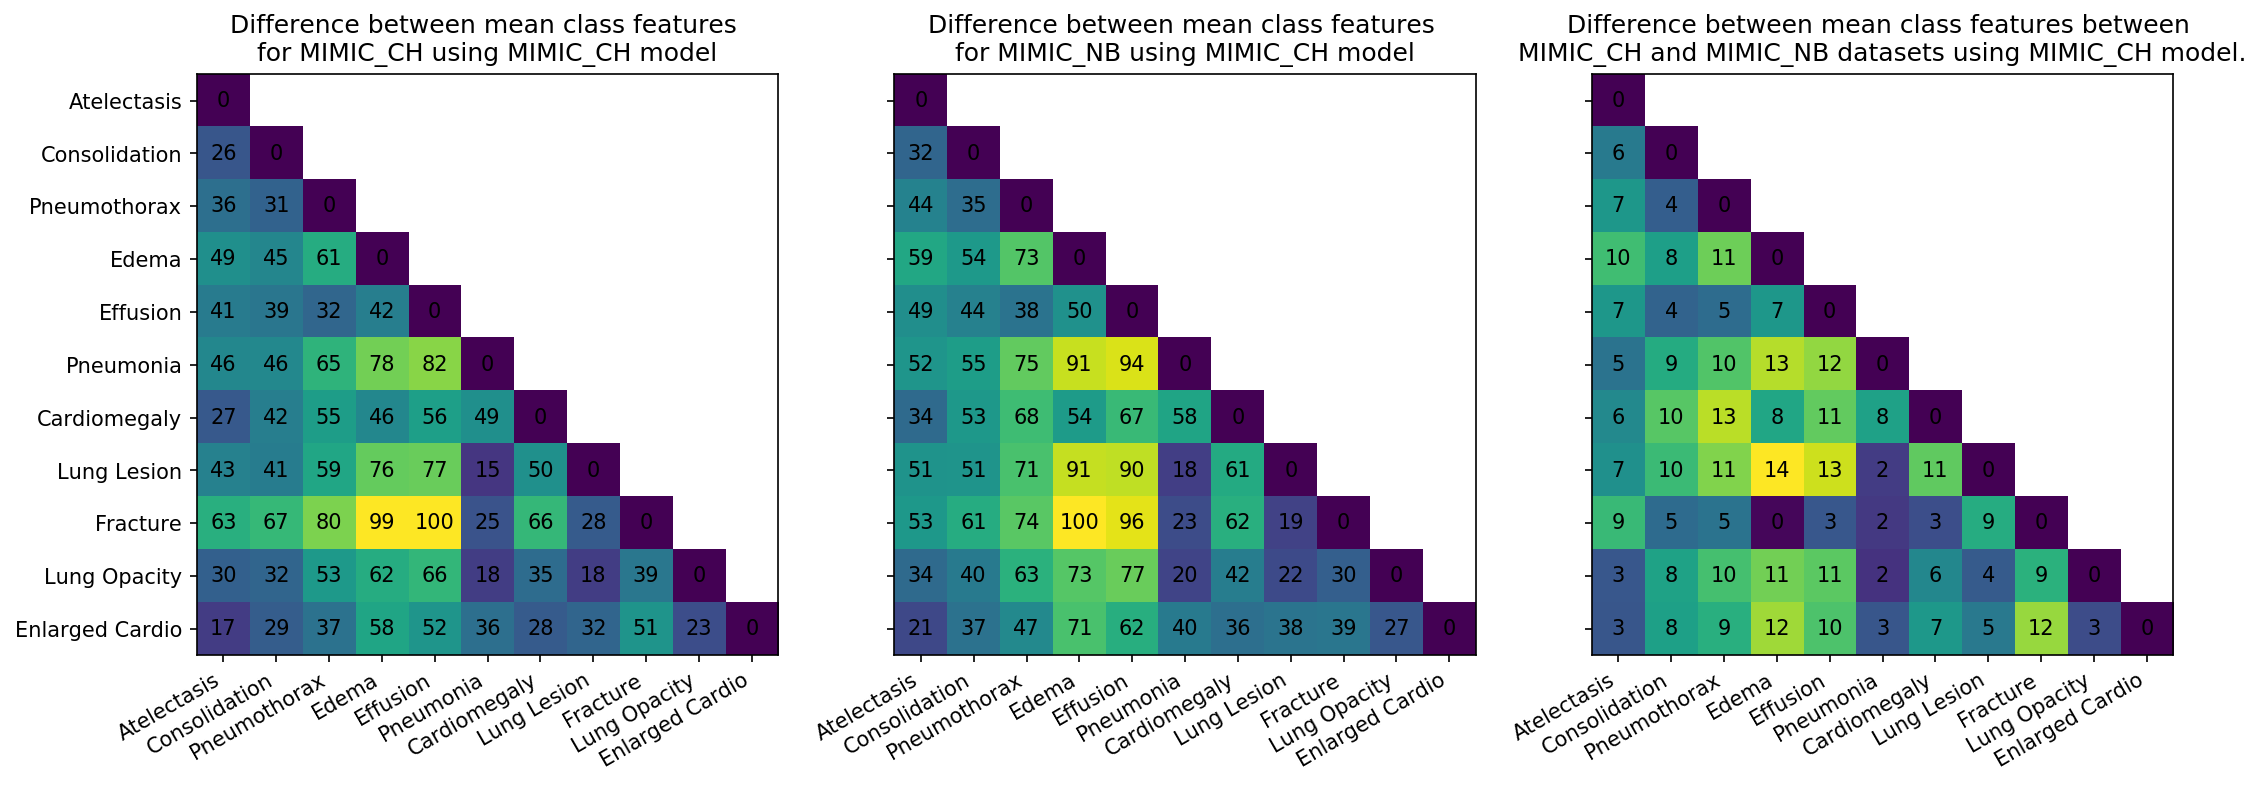

In [73]:
#plt.figure(0, figsize=(7, 7), dpi=100)
f, axs = plt.subplots(1, 3, figsize=(17, 15), dpi=150, sharey=True)

for i, dd in enumerate([dm1, dm2, dm]):
    axs[i].imshow(dd);
    valid = np.nansum(datasetz[this_model].labels, axis=0) > 0
    size = valid.sum()
    #size=14

    axs[i].set_xticks(range(size));
    axs[i].set_xticklabels(np.array(pathos)[valid])
    plt.setp(axs[i].get_xticklabels(), rotation=30, horizontalalignment='right')

    axs[i].set_yticks(range(size));
    axs[i].set_yticklabels(np.array(pathos)[valid])

    x_start = -0.5
    x_end = size-0.5
    y_start = -0.5
    y_end = size-0.5

    # Add the text
    jump_x = (x_end - x_start) / (2.0 * size)
    jump_y = (y_end - y_start) / (2.0 * size)
    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for y_index, y in enumerate(y_positions):
        for x_index, x in enumerate(x_positions):
            if ~np.isnan(dd[y_index, x_index]):
                label = str(int(dd[y_index, x_index]*100))[:4]
                text_x = x + jump_x
                text_y = y + jump_y
                axs[i].text(text_x, text_y, label, color='black', ha='center', va='center')

#f.suptitle('This is a somewhat long figure title', fontsize=16)
axs[0].set_title("Difference between mean class features \nfor {} using {} model".format(a_dataset, this_model));
axs[1].set_title("Difference between mean class features \nfor {} using {} model".format(b_dataset, this_model));
axs[2].set_title("Difference between mean class features between \n{} and {} datasets using {} model.".format(a_dataset, b_dataset, this_model));


In [28]:
# singlelabel = np.nanargmax(labels, axis=1)
# singlelabel

In [29]:
# #balance
# toselect = []
# for i in range(3):
#     for j in [0,1,2]:
#         pos = np.where((origin == i) & (singlelabel == j))[0][:400]
#         print(pos.shape)
#         toselect.append(pos)
# toselect = np.concatenate(toselect)

In [27]:
#singlelabel[np.nansum(labels[:,:14], axis=1) == 0] = -2

In [147]:
model_names = ["NIH", "PC", "CheX", "MIMIC_CH", "MIMIC_NB", "nihpcchexmimic_chmimic_nbgoogle"]
model_names

['NIH',
 'PC',
 'CheX',
 'MIMIC_CH',
 'MIMIC_NB',
 'nihpcchexmimic_chmimic_nbgoogle']

In [186]:
testset_name = "MIMIC_CH"

In [187]:
testset_name

'MIMIC_CH'

In [188]:
features = {}
for model_name in model_names:
    features[model_name] = pickle.load(open("features-m{}-ts{}.pkl".format(model_name, testset_name), "br"))

In [189]:
#subset = [k in [1,2,8] for k in singlelabel]

In [190]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(outputs[toselect])
# X_embedded.shape

In [191]:
outputs, labels, origin = features["nihpcchexmimic_chmimic_nbgoogle"]

In [209]:
toselect = np.nansum(labels, axis=1) != 0

In [210]:
import umap
reducer = umap.UMAP()
X_embedded = reducer.fit_transform(outputs[toselect])
X_embedded.shape

/home/cohenjos/.local/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


(6295, 2)

In [31]:
%matplotlib inline

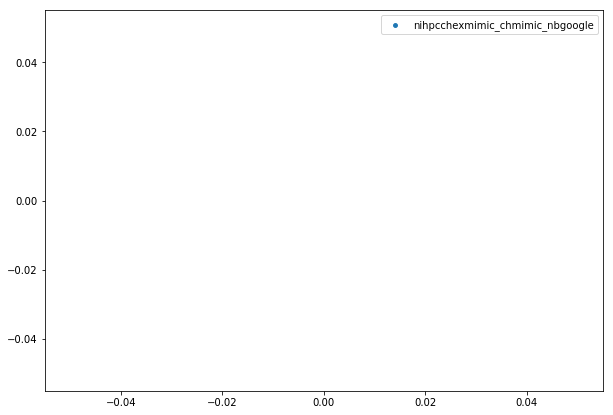

In [194]:
plt.figure(0, figsize=(10, 7))
for ori,name in enumerate(model_names):#zip([0,1,2], ["NIH","PC","CheX"]):
    plt.scatter(X_embedded[origin == ori][:,0], X_embedded[origin == ori][:,1], 
                s=15, cmap=plt.get_cmap("jet"), label=name);
plt.legend();


In [63]:
# labels

In [159]:
# plt.figure(0, figsize=(15, 10))
# for cat in [0,1,2,3]:#range(5):
#     plt.scatter(X_embedded[singlelabel == cat][:,0], X_embedded[singlelabel == cat][:,1], 
#                 s=15, cmap=plt.get_cmap("jet"), label=datasetz["NIH"].pathologies[cat]);
# plt.legend();



In [160]:
cm=plt.get_cmap("jet")
colors = cm(np.linspace(0.5, 1, 14))

In [161]:
highlight = ["Infiltration", 'Consolidation','Pneumonia']

In [195]:
#toselect = np.zeros(labels.shape[0]) == 0

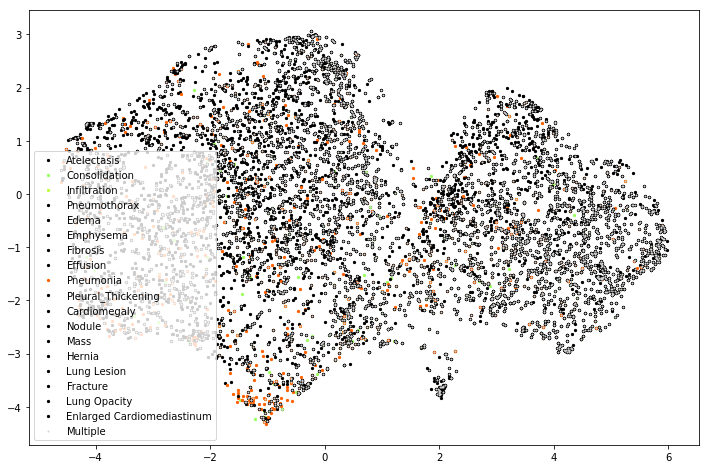

In [211]:
plt.figure(0, figsize=(12, 8))

# none = np.nansum(labels[toselect], axis=1) == 0
# plt.scatter(X_embedded[none][:,0], X_embedded[none][:,1], 
#             c="yellow", label="None", s=10);

for cat in range(18):
    color = colors[cat] if datasetz["NIH"].pathologies[cat] in highlight else "black"
    plt.scatter(X_embedded[labels[toselect][:,cat] == 1][:,0], 
                X_embedded[labels[toselect][:,cat] == 1][:,1], 
                label=datasetz["NIH"].pathologies[cat], s=5, color=color);

multi = np.nansum(labels[toselect], axis=1) > 1
plt.scatter(X_embedded[multi][:,0], X_embedded[multi][:,1], 
            c="lightgray", label="Multiple", s=1);

    
plt.legend();


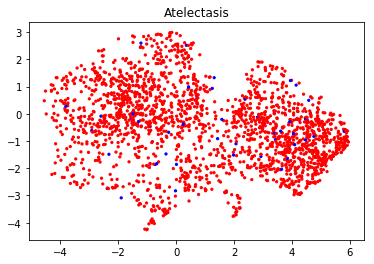

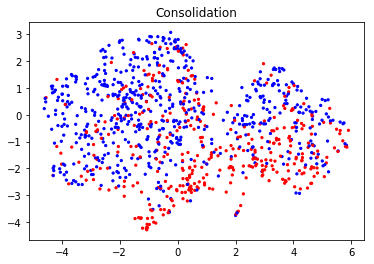

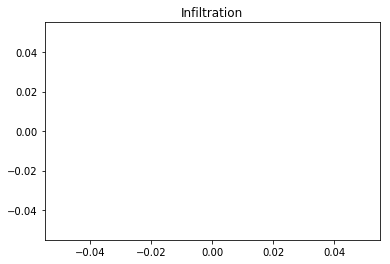

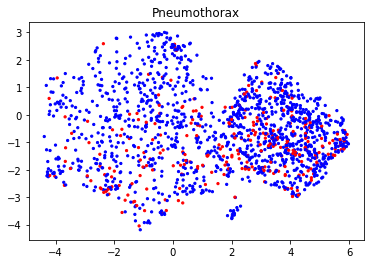

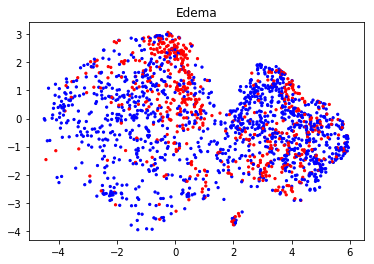

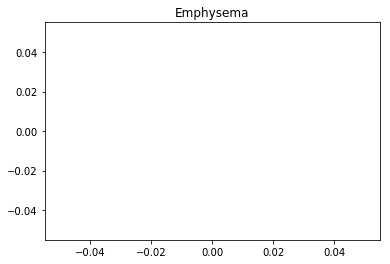

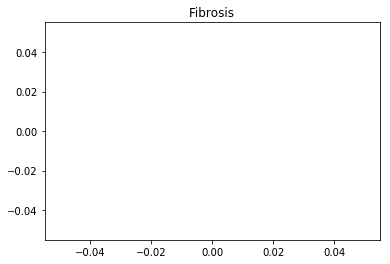

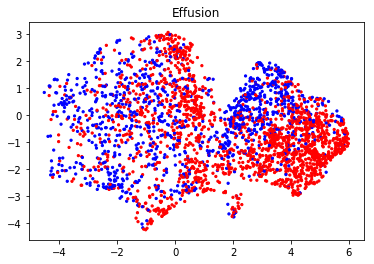

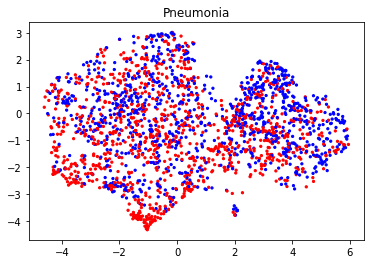

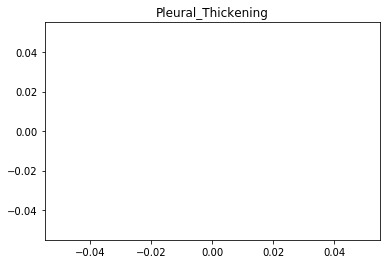

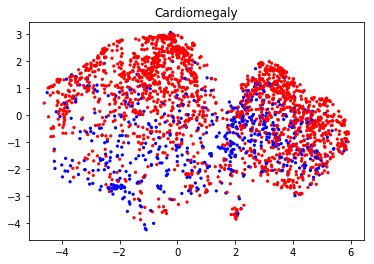

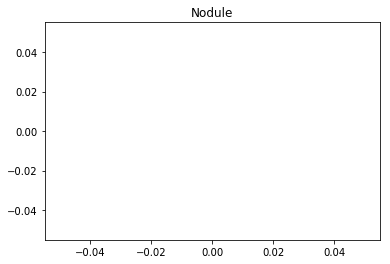

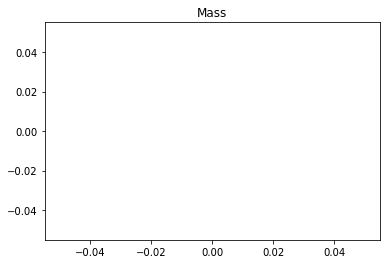

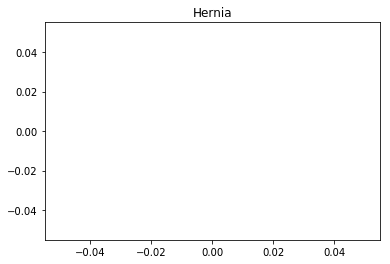

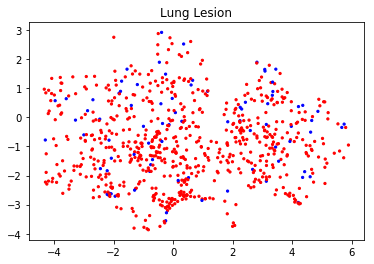

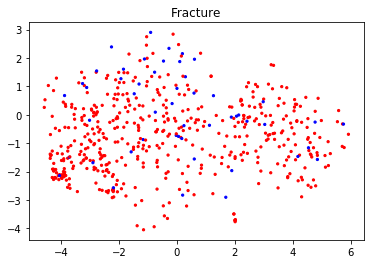

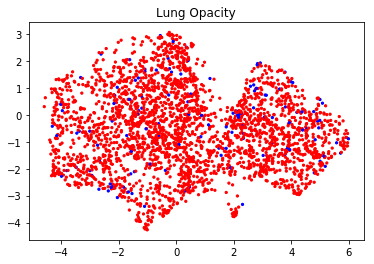

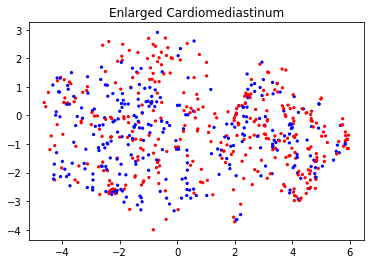

In [213]:
for i, name in enumerate(datasetz["NIH"].pathologies):
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels[toselect][:,i], s=5, cmap=plt.get_cmap("bwr"));
    plt.title(name)
    plt.show()

In [125]:
# for cat in range(30):
#     plt.scatter(X_embedded[cat][0], X_embedded[cat][1], s=1);
#     plt.annotate(cat%10,(X_embedded[cat][0], X_embedded[cat][1]))
# plt.legend();

In [107]:
!ls /home/cohenjos/scratch/concept-embedding2/*best* | grep "nihpcchexmimic_chmimic_nbgoogle"

/home/cohenjos/scratch/concept-embedding2/nihpcchexmimic_chmimic_nbgoogle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt
/home/cohenjos/scratch/concept-embedding2/nihpcchexmimic_chmimic_nbgoogle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt
/home/cohenjos/scratch/concept-embedding2/nihpcchexmimic_chmimic_nbgoogle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt


In [28]:
model_dataset = "nihpcchexmimic_chmimic_nbgoogle"

In [109]:
model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt".format(model_dataset))
weight = model.classifier.weight.detach().cpu().numpy()


In [117]:
def get_weights(seed=0):
    model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(model_dataset, seed))
    weight = model.classifier.weight.detach().cpu().numpy()
    return weight
dmatrix = np.mean([sklearn.metrics.pairwise_distances(get_weights(i), metric="l2") for i in range(3)], axis=0)
    

In [33]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2, perplexity=2).fit_transform(weight)
# X_embedded.shape

In [34]:
# import umap
# reducer = umap.UMAP()
# X_embedded = reducer.fit_transform(weight)
# X_embedded.shape

In [111]:
import sklearn, sklearn.decomposition
X_embedded = sklearn.decomposition.PCA(n_components=2).fit_transform(weight)
X_embedded.shape

(18, 2)

In [112]:
#notnull = np.nansum(datasetz[model_dataset].labels,axis=0) > 0

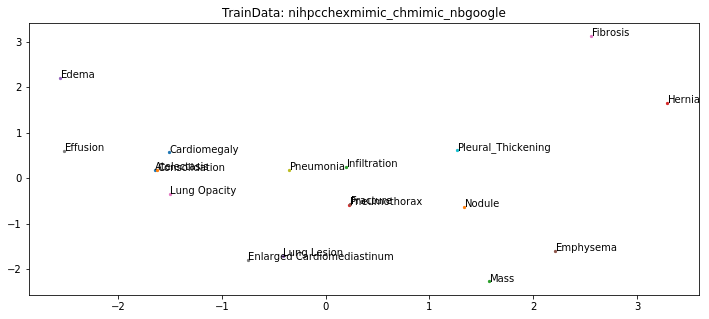

In [113]:
plt.figure(0, figsize=(12, 5))

for cat in range(18):
#    if model_dataset=="Merge" or notnull[cat]:
    plt.scatter(X_embedded[cat][0], 
                X_embedded[cat][1], 
                label=datasetz["NIH"].pathologies[cat], s=5);
    plt.annotate(datasetz["NIH"].pathologies[cat],(X_embedded[cat][0], X_embedded[cat][1]))

plt.title("TrainData: " + model_dataset);

In [102]:
# plt.figure(0, figsize=(12, 5))

# for cat in range(18):
# #    if model_dataset=="Merge" or notnull[cat]:
#     plt.scatter(X_embedded[cat][0], 
#                 X_embedded[cat][1], 
#                 label=datasetz["NIH"].pathologies[cat], s=5);
#     plt.annotate(datasetz["NIH"].pathologies[cat],(X_embedded[cat][0], X_embedded[cat][1]))

# plt.title("TrainData: " + model_dataset);

In [130]:
model_names = ['NIH', 'PC', 'CheX', 'MIMIC_CH', 'MIMIC_NB', "nihpcchexmimic_chmimic_nbgoogle"]

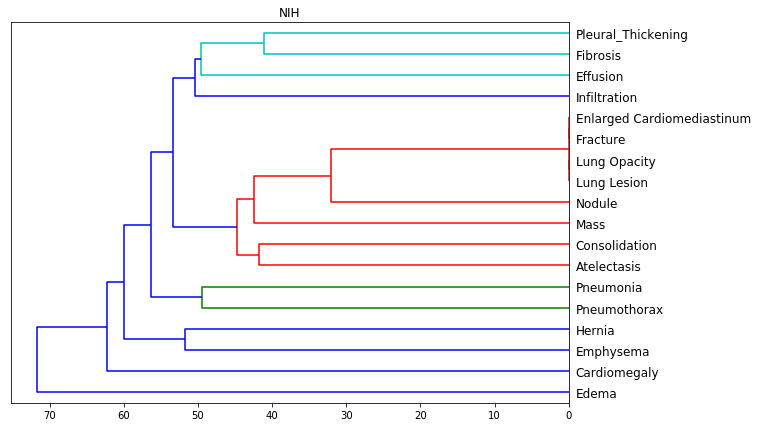

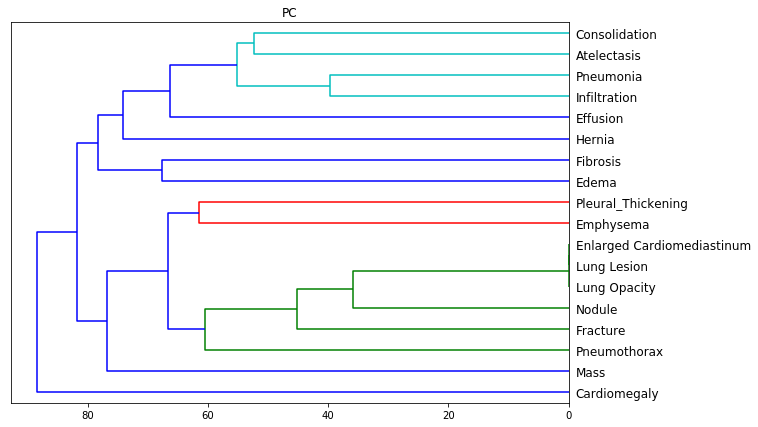

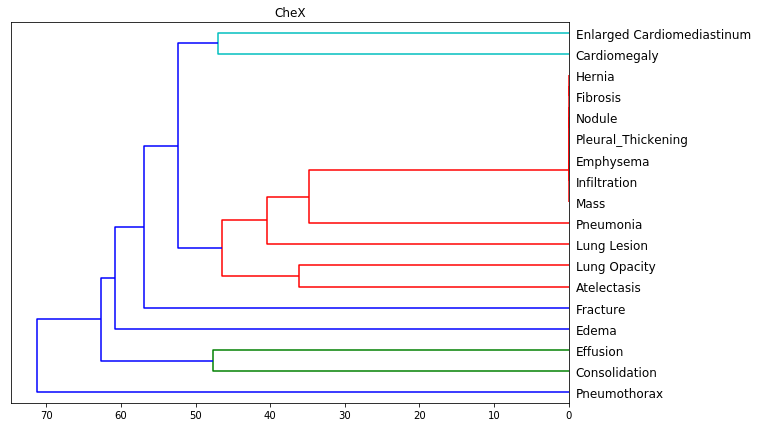

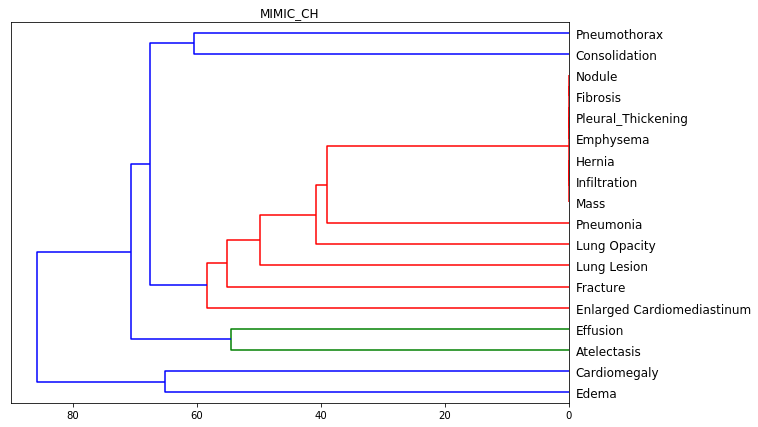

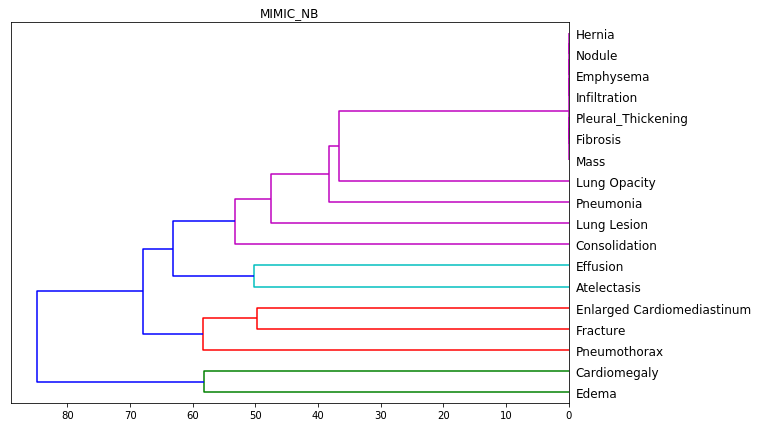

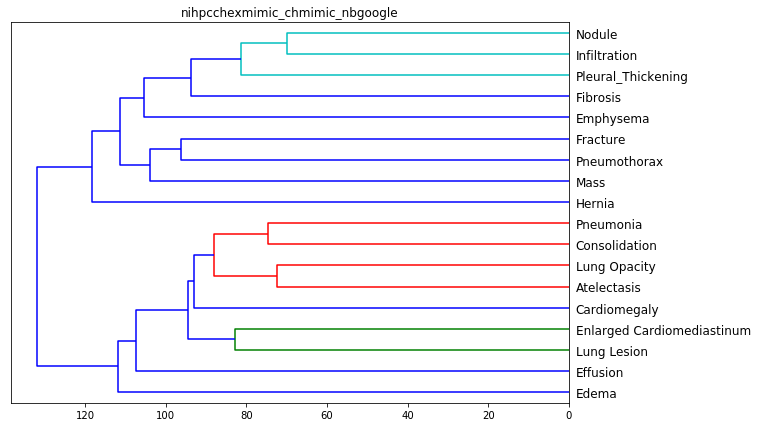

In [136]:
def get_weights(model_name, seed):
    model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(model_name.lower(), seed))
    weights = model.classifier.weight.detach().cpu().numpy()
    return weights


for model_name in model_names:

    dmatrix = np.mean([sklearn.metrics.pairwise_distances(get_weights(model_name, i), metric="l1") for i in range(3)], axis=0)


    from scipy.cluster.hierarchy import dendrogram, linkage
    from matplotlib import pyplot as plt
    import scipy

    linked = linkage(scipy.spatial.distance.squareform(dmatrix), 'complete', metric="l1")

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='left',
                labels=datasetz["NIH"].pathologies,
                distance_sort='descending',
                show_leaf_counts=True)#, leaf_rotation=90)
    plt.title(model_name)
    plt.show()

In [104]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from matplotlib import pyplot as plt

# linked = linkage(weight, 'complete')

# plt.figure(figsize=(10, 7))
# dendrogram(linked,
#             orientation='left',
#             labels=datasetz["NIH"].pathologies,
#             distance_sort='descending',
#             show_leaf_counts=True)#, leaf_rotation=90)
# plt.show()

In [96]:
weight.shape

(18, 1024)

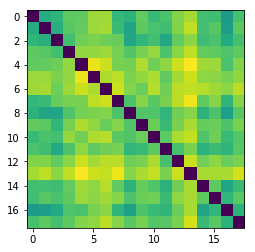

In [86]:
model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt".format(model_dataset))
weight = model.classifier.weight.detach().cpu().numpy()
d = sklearn.metrics.pairwise_distances(weight, metric="l2")
plt.imshow(d)

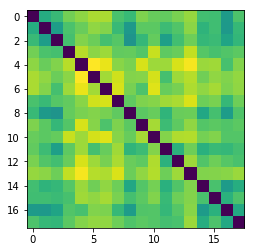

In [78]:
model = torch.load("/home/cohenjos/scratch/concept-embedding2/{}-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt".format(model_dataset))
weight = model.classifier.weight.detach().cpu().numpy()
d = sklearn.metrics.pairwise_distances(weight, metric="l2")
plt.imshow(d)

In [50]:
def get_text_positions(text, x_data, y_data, txt_width, txt_height):
    a = zip(y_data, x_data)
    text_positions = list(y_data)
    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height) 
                            and (abs(i[1] - x) < txt_width * 2) and i != (y,x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height: #True == collision
                differ = np.diff(sorted_ltp, axis=0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height*1.01
                for k, (j, m) in enumerate(differ):
                    #j is the vertical distance between words
                    if j > txt_height * 2: #if True then room to fit a word in
                        a[index] = (sorted_ltp[k][0] + txt_height, a[index][1])
                        text_positions[index] = sorted_ltp[k][0] + txt_height
                        break
    return text_positions
def text_plotter(text, x_data, y_data, text_positions, txt_width,txt_height):
    for z,x,y,t in zip(text, x_data, y_data, text_positions):
        plt.annotate(str(z), xy=(x-txt_width/2, t), size=12)
        if y != t:
            plt.arrow(x, t,0,y-t, color='red',alpha=0.3, width=txt_width*0.1, 
                head_width=txt_width, head_length=txt_height*0.5, 
                zorder=0,length_includes_head=True)


In [244]:
# import torch
# path = "/lustre04/scratch/cohenjos/concept-embedding2/nih-pc-chex-mimic_ch-google-openi-densenet121-lc-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt"

# model = torch.load(path, map_location="cpu")
# weight = model.classifier.weight.detach().cpu().numpy()

In [245]:
# import sklearn, sklearn.decomposition
# X_embedded = sklearn.decomposition.PCA(n_components=2).fit_transform(weight)
# X_embedded.shape

In [246]:
# weight.shape

In [48]:
dataset_names = ["NIH", "PC", "CheX", "MIMIC_CH", "Google", "OpenI"]

In [247]:
# plt.figure(0, figsize=(12, 8), dpi=150)

# cm=plt.get_cmap("jet")
# colors = cm(np.linspace(0.5, 1, 18))

# texts = []
# for offset, dname in zip(np.arange(0,weight.shape[0], 18), dataset_names):
#     notnull = np.nansum(datasetz[dname].labels,axis=0) > 0
#     for cat in range(len(datasets.xray.default_pathologies)):
#         if ~notnull[cat]:
#             continue
#         plt.scatter(X_embedded[cat+offset][0], 
#                     X_embedded[cat+offset][1], s=8, color=colors[cat]);
#         t = plt.text(X_embedded[cat+offset][0], X_embedded[cat+offset][1],
#                     datasets.xray.default_pathologies[cat],
#                  #"{} ({})".format(datasets.xray.default_pathologies[cat], dname),
#                      fontsize=5)
#         texts.append(t)
        
# #adjustText.adjust_text(texts)
# plt.legend();
# #plt.title("TrainData: " + path);

In [59]:
import torch
path = "/lustre04/scratch/cohenjos/concept-embedding2/nih-pc-chex-mimic_ch-google-openi-densenet121-lc-d121-tw-lr001-rot45-tr15-sc15-seed1-best.pt"
#path = "/lustre04/scratch/cohenjos/concept-embedding2/nih-pc-chex-mimic_ch-google-openi-densenet121-lc-lcr-d121-tw-lr001-rot45-tr15-sc15-seed2-best.pt"

model = torch.load(path, map_location="cpu")
weight = model.classifier.weight.detach().cpu().numpy()

In [60]:
import sklearn, sklearn.decomposition
X_embedded = sklearn.decomposition.PCA(n_components=2).fit_transform(weight)
X_embedded.shape

(108, 2)

In [61]:
import adjustText
from scipy.spatial.distance import pdist, squareform

In [77]:
# import sklearn, sklearn.manifold
# X_embedded = sklearn.manifold.TSNE(n_components=2, perplexity=30).fit_transform(weight)
# X_embedded.shape

In [74]:
second_closest = np.sort(squareform(pdist(X_embedded)))[:,2]

In [75]:
second_closest

array([2.85854608e-01, 1.84453535e-01, 1.26151531e-01, 2.69173355e-01,
       8.61745228e-01, 3.88815395e-01, 1.54543231e-01, 2.25430229e-01,
       6.66518977e-01, 2.22058034e-01, 4.27053828e-01, 4.51377436e-01,
       2.33271585e-01, 3.07561791e-01, 1.20137002e-07, 1.19209290e-07,
       1.27315577e-07, 1.27315577e-07, 3.02585090e-01, 1.07603135e-01,
       9.56916533e-02, 6.73227115e-01, 6.84146183e-01, 5.34486390e-01,
       1.46761938e-01, 2.90089884e-01, 6.37555727e-02, 3.26515848e-01,
       2.85864318e-01, 3.36049433e-01, 8.64997100e-01, 1.70893162e-01,
       1.20137002e-07, 1.75584117e-01, 1.49011612e-08, 5.96046448e-08,
       1.47846797e-01, 1.58280699e-01, 2.98023224e-08, 1.74529615e-01,
       1.55061611e-01, 1.19209290e-07, 1.20137002e-07, 1.98945053e-01,
       3.15239799e-01, 1.04308128e-07, 3.15239799e-01, 1.22878123e-07,
       2.38418579e-07, 1.04308128e-07, 1.70516120e-01, 1.74529615e-01,
       1.55061611e-01, 3.54614507e-01, 1.20137002e-07, 8.94069672e-08,
      

/home/cohenjos/.local/lib/python3.7/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


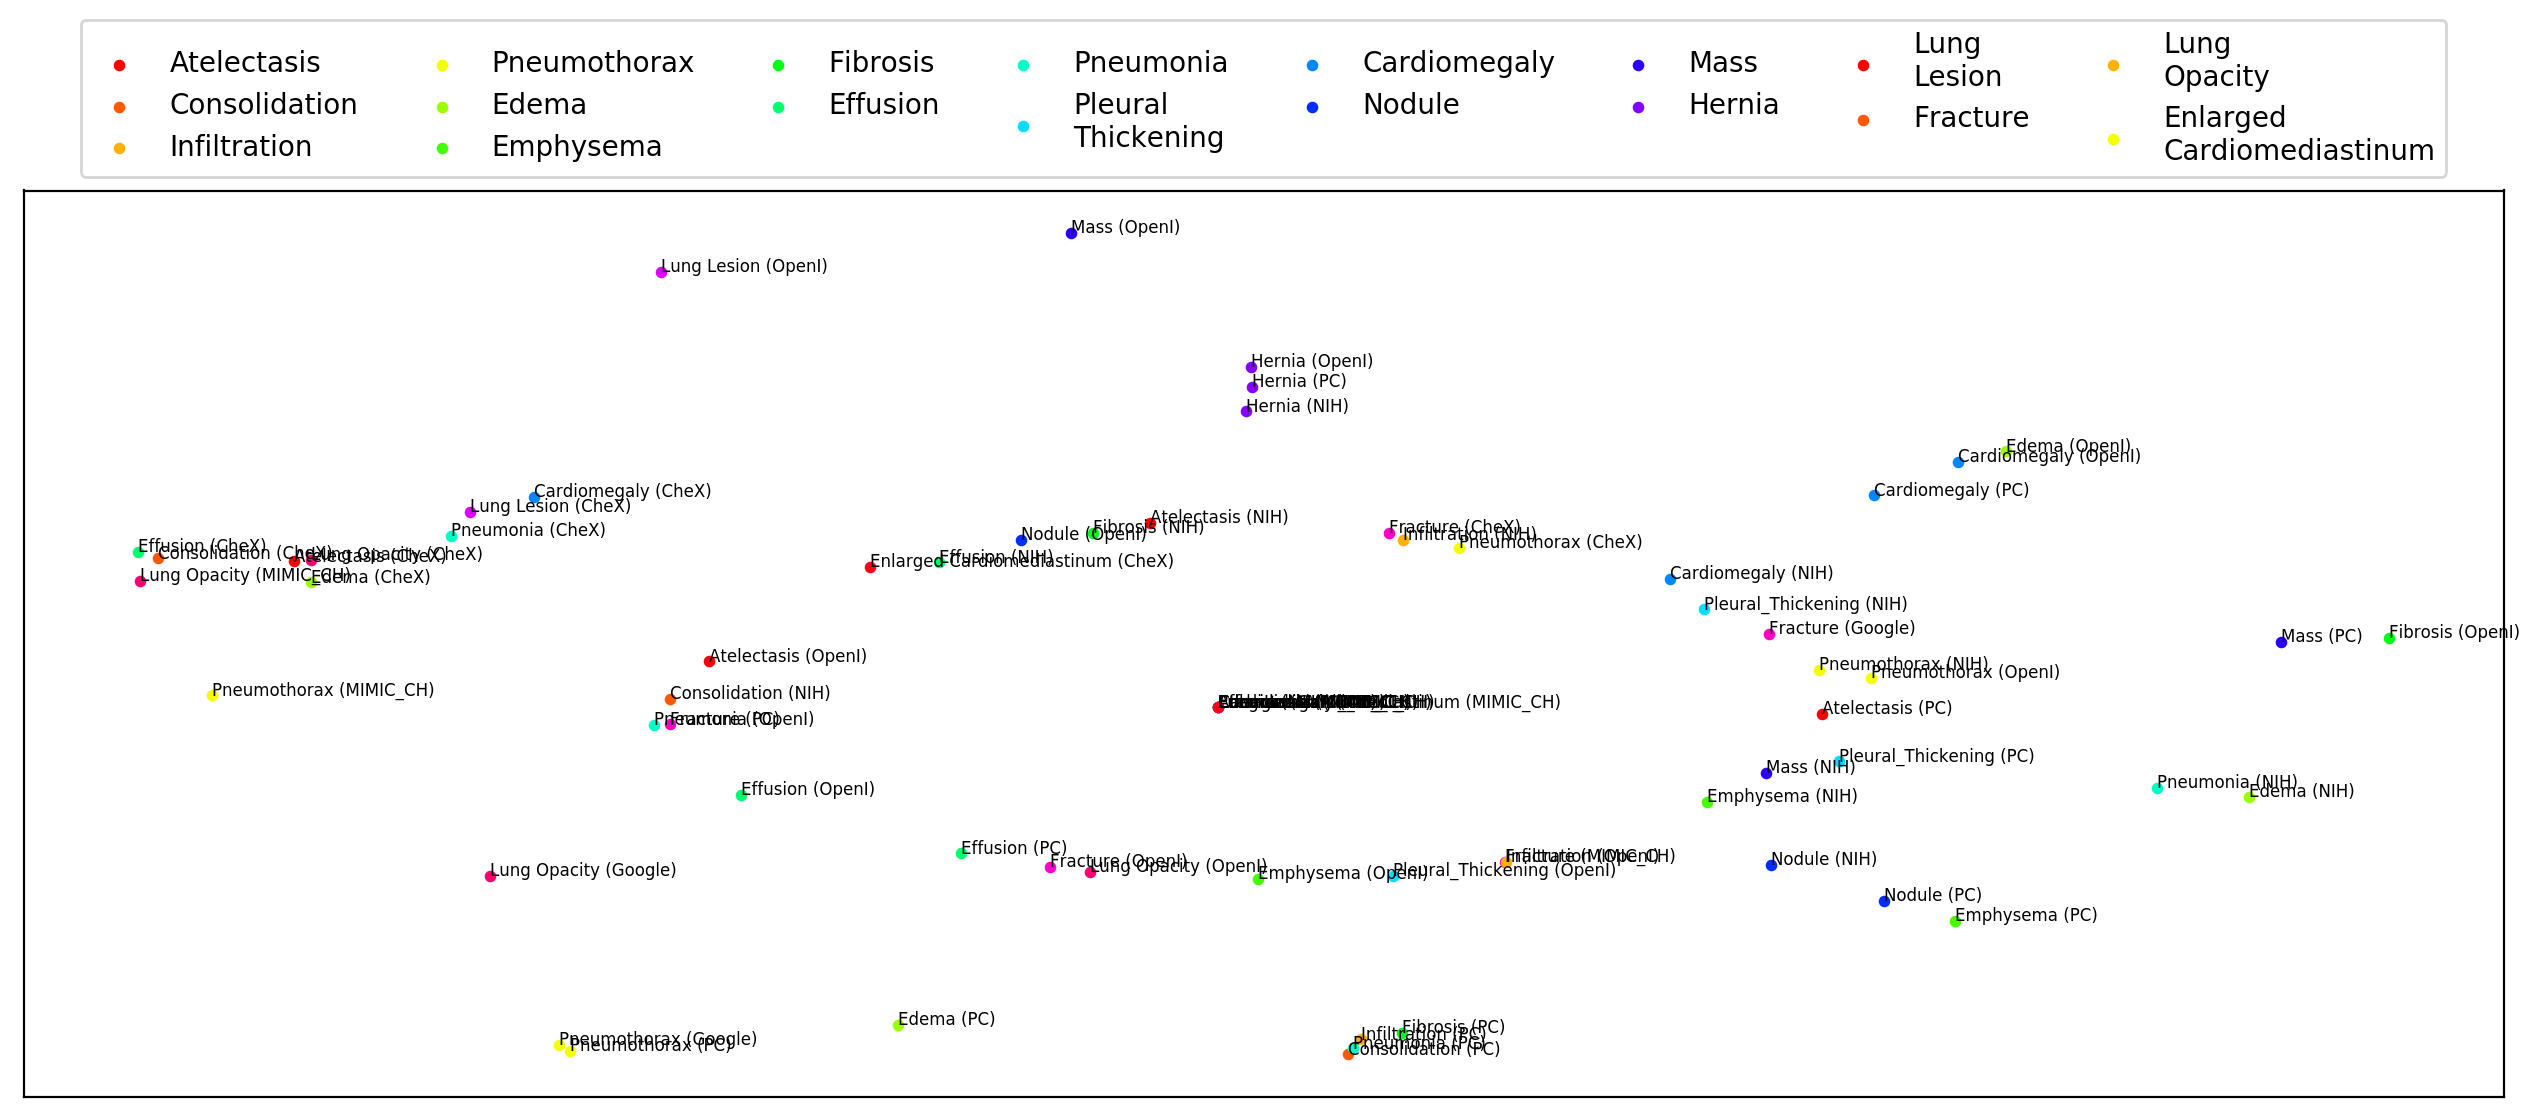

In [76]:
plt.figure(0, figsize=(16, 6), dpi=200)

cm=plt.get_cmap("hsv")
colors = cm(np.linspace(0, 1, 18))

pathos = [p.replace("_"," ").replace(" ","\n") for p in datasets.xray.default_pathologies]

texts = []
texts2 = []
labs = {}
for offset, dname in zip(np.arange(0,weight.shape[0], 18), dataset_names):
    notnull = np.nansum(datasetz[dname].labels,axis=0) > 0
    for cat in range(len(datasets.xray.default_pathologies)):
        if ~notnull[cat]:
            continue
        
        labs[cat] = plt.scatter(X_embedded[cat+offset][0], 
                                X_embedded[cat+offset][1], 
                                s=10, 
                                color=colors[cat], 
                                label=pathos[cat]);
        
        #if X_embedded[cat+offset][1] < 0.5:
        t = plt.text(X_embedded[cat+offset][0], X_embedded[cat+offset][1],
                    #datasets.xray.default_pathologies[cat],
                     "{} ({})".format(datasets.xray.default_pathologies[cat], dname),
                     fontsize=6)
        if second_closest[cat+offset] < 2:
            texts.append(t)
        else:
            texts2.append(t)
#plt.ylim(-0.7,0.25) 
plt.xticks([])
plt.yticks([])     
#adjustText.adjust_text(texts2)
#adjustText.adjust_text(texts , arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
#plt.legend(labs, labels=pathos, loc='center left', bbox_to_anchor=(1, 0.5));
plt.legend(labs, labels=pathos, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=8);
#plt.title("TrainData: " + path);

In [56]:
import sklearn, sklearn.decomposition

In [209]:
dataset_names = ["NIH", "PC", "CheX", "MIMIC_CH", "Google", "OpenI"]
notnull = [np.nansum(datasetz[dname].labels,axis=0) > 0 for dname in dataset_names]
notnull = np.array(notnull)
notnull

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False, False],
       [ True,  True, False,  True,  True, False, False,  True,  True,
        False,  True, False, False, False,  True,  True,  True,  True],
       [ True,  True, False,  True,  True, False, False,  True,  True,
        False,  True, False, False, False,  True,  True,  True,  True],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False],
       [ True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False]])

In [210]:
toplots_lc = []
for seed in range(3):
    path = "/lustre04/scratch/cohenjos/concept-embedding2/nih-pc-chex-mimic_ch-google-openi-densenet121-lc-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(seed)

    model = torch.load(path, map_location="cpu")
    weight = model.classifier.weight.detach().cpu().numpy()
    
    #weight = sklearn.decomposition.PCA(n_components=2).fit_transform(weight)

    num_labels = len(datasets.xray.default_pathologies)
    num_datasets = weight.shape[0]//num_labels
    weight_stacked = torch.tensor(weight.reshape(num_datasets,num_labels,-1))
    label_concat_reg_lambda = torch.tensor(0.1).float()
    toplot=[]
    for t in range(num_labels):
        towork = weight_stacked[:,t][notnull[:,t]]
        #print(datasets.xray.default_pathologies[t], towork.shape)
        dists = torch.pdist(towork, p=2).mean()
        toplot.append(dists.numpy())
    toplot = np.array(toplot)
    toplots_lc.append(toplot/toplot.max())
    
toplots_lcr = []
for seed in range(3):
    path = "/lustre04/scratch/cohenjos/concept-embedding2/nih-pc-chex-mimic_ch-google-openi-densenet121-lc-lcr-d121-tw-lr001-rot45-tr15-sc15-seed{}-best.pt".format(seed)

    model = torch.load(path, map_location="cpu")
    weight = model.classifier.weight.detach().cpu().numpy()
    
    #weight = sklearn.decomposition.PCA(n_components=2).fit_transform(weight)
    
    num_labels = len(datasets.xray.default_pathologies)
    num_datasets = weight.shape[0]//num_labels
    weight_stacked = torch.tensor(weight.reshape(num_datasets,num_labels,-1))
    label_concat_reg_lambda = torch.tensor(0.1).float()
    toplot=[]
    for t in range(num_labels):
        towork = weight_stacked[:,t][notnull[:,t]]
        #print(datasets.xray.default_pathologies[t], towork.shape)
        dists = torch.pdist(towork, p=2).mean()
        toplot.append(dists.numpy())
    toplot = np.array(toplot)
    toplots_lcr.append(toplot/toplot.max())
    

In [227]:
reorder = np.argsort(np.asarray(toplots_lcr).mean(0))
#reorder = neworder

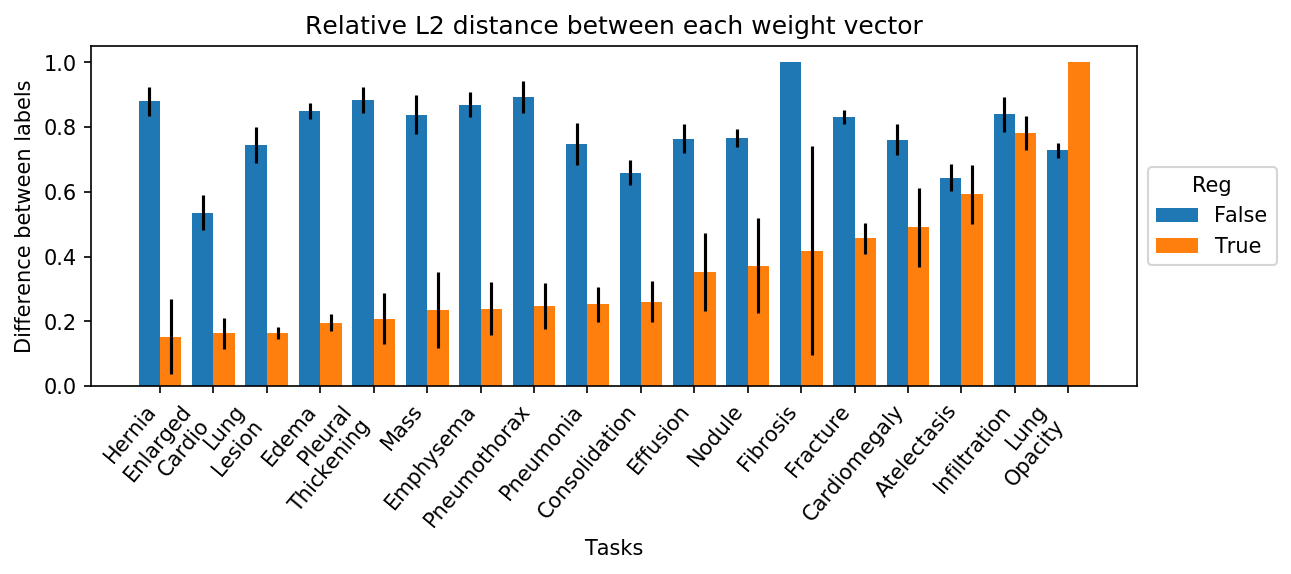

In [228]:
plt.figure(0, figsize=(9, 3), dpi=150)
#plt.bar(range(len(toplot)),results/toplot.max())
index = np.arange(toplot.shape[0])  # the label locations
width = 0.4  # the width of the bars

pathos = [p.replace("_"," ").replace(" ","\n").replace("Cardiomediastinum","Cardio")  for p in datasets.xray.default_pathologies]
plt.bar(index-0.2+0*width, np.asarray(toplots_lc).mean(0)[reorder], width, yerr=np.asarray(toplots_lc).std(0)[reorder], label="False");
plt.bar(index-0.2+1*width, np.asarray(toplots_lcr).mean(0)[reorder], width, yerr=np.asarray(toplots_lcr).std(0)[reorder],  label="True");

plt.xticks(index,np.array(pathos)[reorder],
           rotation='50',horizontalalignment="right");
plt.xlabel("Tasks")
plt.ylabel("Difference between labels")

plt.title("Relative L2 distance between each weight vector")
plt.legend(title="Reg", loc='center left', bbox_to_anchor=(1, 0.5));


Text(43.208333333333336, 0.5, 'Mean AUC of cross-domain eval')

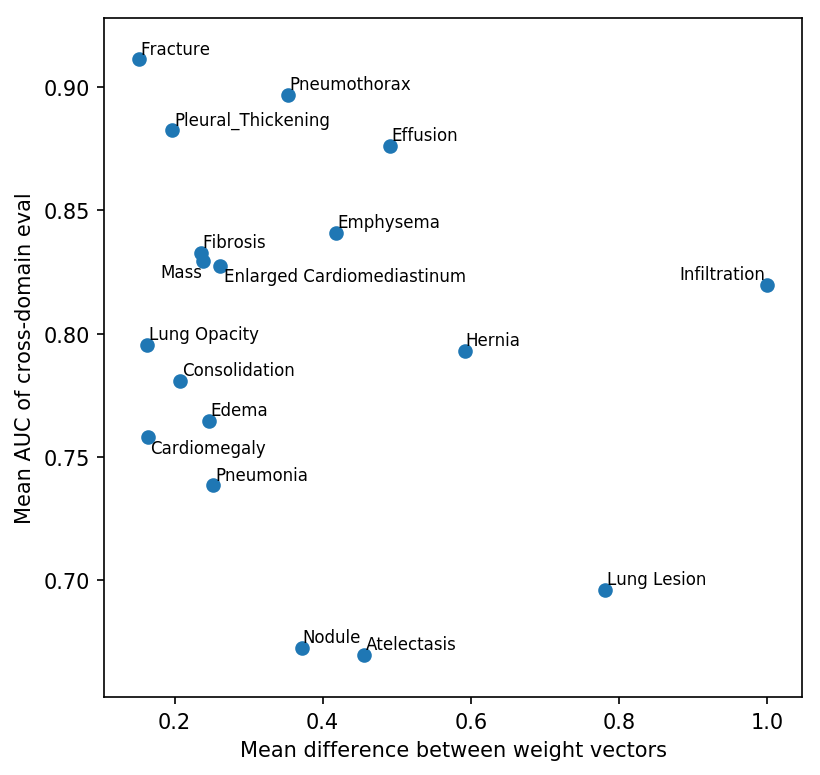

In [229]:
import adjustText
plt.figure(0, figsize=(6, 6), dpi=150)
plt.scatter(np.asarray(toplots_lcr).mean(0), overall_score)
loc = zip(np.asarray(toplots_lcr).mean(0), overall_score, np.array(datasets.xray.default_pathologies)[reorder])
texts = []
for x,y,task in loc:
    texts.append(plt.text(x, y, task,fontsize=8))
    
adjustText.adjust_text(texts)
plt.xlabel("Mean difference between weight vectors")
plt.ylabel("Mean AUC of cross-domain eval")

In [ ]:
np.asarray(toplots_lcr).mean(0)

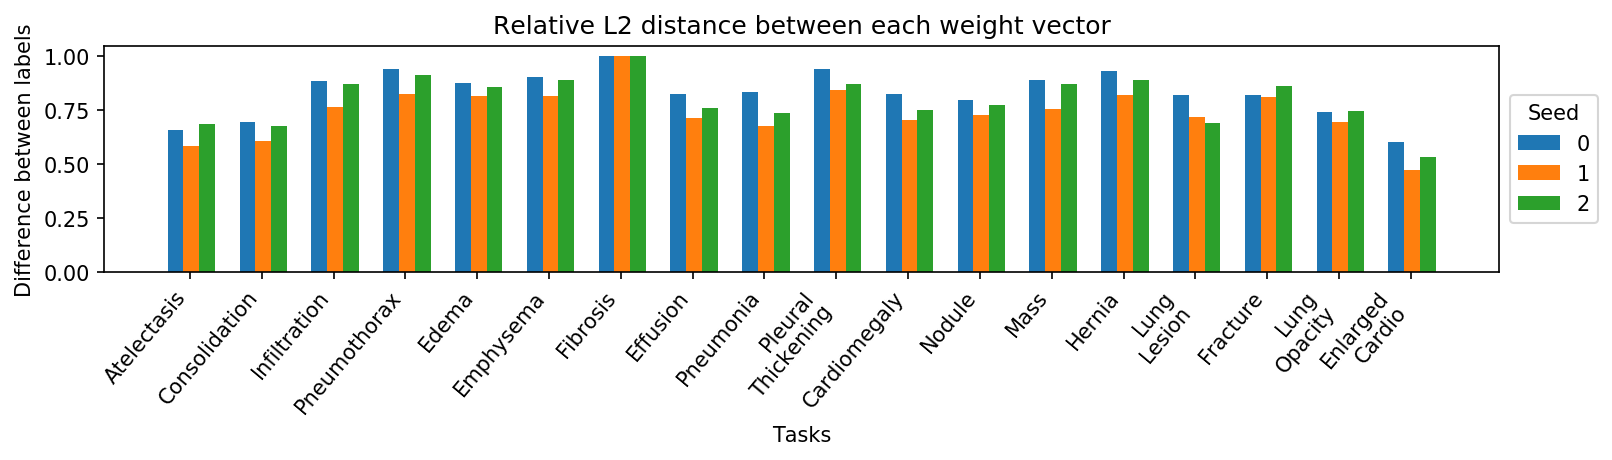

In [52]:
plt.figure(0, figsize=(12, 2), dpi=150)
#plt.bar(range(len(toplot)),results/toplot.max())
index = np.arange(len(toplots_lc[0]))  # the label locations
width = 0.22  # the width of the bars

pathos = [p.replace("_"," ").replace(" ","\n").replace("Cardiomediastinum","Cardio")  for p in datasets.xray.default_pathologies]
for seed in range(3):
    plt.bar(index-0.2+seed*width, toplots_lc[seed], width, label=seed);
    
plt.xticks(index,np.array(pathos),
           rotation='50',horizontalalignment="right");
plt.xlabel("Tasks")
plt.ylabel("Difference between labels")

plt.title("Relative L2 distance between each weight vector")
plt.legend(title="Seed", loc='center left', bbox_to_anchor=(1, 0.5));

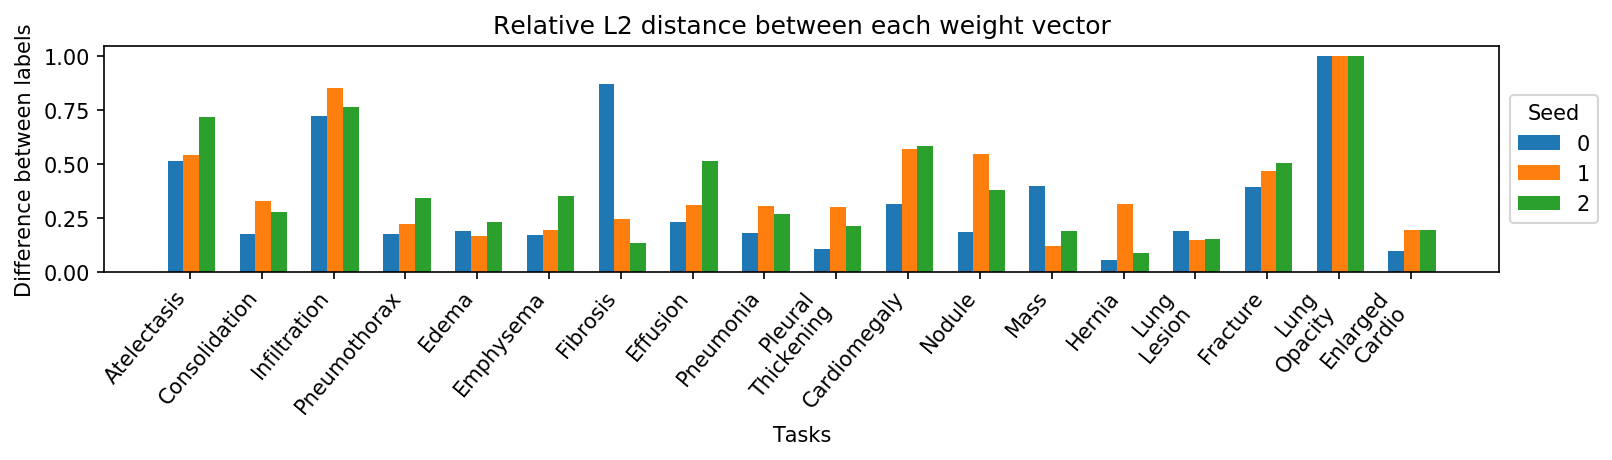

In [53]:
plt.figure(0, figsize=(12, 2), dpi=150)
#plt.bar(range(len(toplot)),results/toplot.max())
index = np.arange(len(toplots_lc[0]))  # the label locations
width = 0.22  # the width of the bars

pathos = [p.replace("_"," ").replace(" ","\n").replace("Cardiomediastinum","Cardio")  for p in datasets.xray.default_pathologies]
for seed in range(3):
    plt.bar(index-0.2+seed*width, toplots_lcr[seed], width, label=seed);
    
plt.xticks(index,np.array(pathos),
           rotation='50',horizontalalignment="right");
plt.xlabel("Tasks")
plt.ylabel("Difference between labels")

plt.title("Relative L2 distance between each weight vector")
plt.legend(title="Seed", loc='center left', bbox_to_anchor=(1, 0.5));